## <b>4.3 PREPROCESSAMENT I ANÀLISI DE DADES</b>

### <b>4.3.3 Anàlisi exploratòria de dades (EDA)</b>

#### <b>4.3.3.1 Preparació i definició de variables</b>

In [4]:
# ============================================================
# 4.3.3.1 PREPARACIÓ I DEFINICIÓ DE VARIABLES (EDA)
# ============================================================
# Objectiu:
#   - Carregar el dataset final transformat per fer-hi EDA (anàlisi exploratòria).
#   - Fer una inspecció ràpida:
#       * dimensions (files, columnes)
#       * dtypes (tipus de dades)
#       * valors nuls i la seva magnitud
#   - Definir i validar el mapa de variables per model:
#       * Model de freqüència (probabilitat de sinistre)
#       * Model de severitat (cost del sinistre)
#       * Targets (variables objectiu)
#       * Flags de qualitat i traçabilitat
#
# Nota:
#   Aquest codi NO transforma ni modifica les dades de fons, només:
#       - les carrega,
#       - fa conversions lleugeres de format (object→numèric si escau),
#       - valida estructura i presència de variables clau.
# ============================================================

import pandas as pd
import numpy as np

# Ajustem opcions de display per veure més columnes i més amples
pd.set_option("display.max_columns", 200)  # fins a 200 columnes visibles
pd.set_option("display.width", 140)        # ample màxim de línia a la consola/notebook

# ------------------------------------------------------------
# 1) CÀRREGA DEL DATASET FINAL PER A L'EDA
# ------------------------------------------------------------

# Ruta del fitxer que servirà com a base de l'EDA
path_eda = "Transformed_motor_insurance_rounded_european.csv"

# Llegim el CSV a un DataFrame de pandas
df = pd.read_csv(path_eda)

print("Dataset EDA carregat correctament")
print("Fitxer:", path_eda)
print("Dimensions (files, columnes):", df.shape)

# Visualitzem les primeres 5 files per fer una inspecció ràpida
print("\nPrimeres 5 files:")
display(df.head())

# ------------------------------------------------------------
# 2) INSPECCIÓ RÀPIDA DE TIPUS I FORMAT (dtypes)
# ------------------------------------------------------------

print("\n--- Tipus de dades inicials (dtypes) ---")

# Mostrem els tipus de cada columna per veure quines són numèriques, object, etc.
display(df.dtypes)

# Detectem columnes de tipus object, que poden contenir cadenes, codis,
# però també números amb coma decimal (format europeu).
obj_cols = df.select_dtypes(include="object").columns.tolist()

print("\n--- Columnes object detectades ---")
print(obj_cols)

# Conversió automàtica de columnes object → float (si escau):
# Intentem transformar columnes object que realment siguin numèriques
# però guardades com a text (possiblement amb coma decimal).
converted_cols = []

for c in obj_cols:
    # 1) Convertim a string
    # 2) Substituïm coma per punt (per poder fer to_numeric)
    # 3) Intentem convertir a numèric; errors="coerce" → valors no convertibles passen a NaN
    temp = pd.to_numeric(
        df[c].astype(str).str.replace(",", ".", regex=False),
        errors="coerce"
    )
    # Criteri de conversió: si almenys el 80% de valors són convertibles a número,
    # assumim que la columna és numèrica i la sobrescrivim.
    if temp.notna().mean() > 0.80:
        df[c] = temp
        converted_cols.append(c)

print("\nColumnes reconvertides a numèriques (si aplicable):")
print(converted_cols)
print("\n--- Tipus després de reconversió ---")

display(df.dtypes)

# ------------------------------------------------------------
# 3) TAULA DE NULS (validació de qualitat)
# ------------------------------------------------------------

# Recompte de nuls per columna
missing_count = df.isna().sum()

# Percentatge de nuls respecte del total de registres
missing_pct = (missing_count / len(df) * 100).round(2)

# Construïm una taula amb recompte i percentatge de nuls
missing_table = (
    pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct})
    .sort_values("missing_count", ascending=False)  # ordre descendent per nº de nuls
)

print("\n--- Taula de valors nuls (top 15) ---")

display(missing_table.head(15))

# Llistem variables amb més d’un 10% de nuls per focalitzar atenció
print("\nVariables amb >10% de nuls:")
print(missing_table[missing_table["missing_pct"] > 10].index.tolist())

# ------------------------------------------------------------
# 4) MAPA DE VARIABLES PER MODEL (freqüència, severitat, flags)
# ------------------------------------------------------------

# Definim explícitament quines variables s’esperen per a cada model.
# Aquesta definició ha de ser coherent amb la fase de preparació anterior.
# Variables d'entrada per al model de FREQÜÈNCIA (classe Has_claims_year)
freq_features = [
    "Driver_age","Licence_age","Vehicle_age","Has_lapse","Policy_duration",
    "Second_driver","Area","Type_risk","Type_fuel","Has_claims_history",
    "Value_vehicle","Power","Premium","Seniority","Policies_in_force",
    "Distribution_channel"
]

# Variables d'entrada per al model de SEVERITAT (Cost_claims_year)
sev_features = [
    "Vehicle_age","Value_vehicle","Power","Type_risk","Area","Policy_duration",
    "Claims_to_premium_ratio","Weight","Cylinder_capacity","Length"
]

# Variables objectiu (targets) per a modelització supervisada
targets = ["Has_claims_year", "Cost_claims_year"]

# Variables de control i flags de qualitat
flags_features = [
    "Has_lapse","Licence_incoherent_flag","Policy_incoherent_flag",
    "Lapse_incoherent_flag","Length_missing_flag"
]

print("\n--- Mapa de variables segons model ---")
print("Variables de freqüència:")
print(freq_features)
print("\nVariables de severitat:")
print(sev_features)
print("\nVariables objectiu (targets):")
print(targets)
print("\nVariables de control i traçabilitat:")
print(flags_features)

# ------------------------------------------------------------
# 5) VALIDACIÓ QUE TOTES LES VARIABLES CLAU EXISTEIXEN
# ------------------------------------------------------------

# Construïm el conjunt de variables que esperem trobar al dataset
expected_cols = set(freq_features + sev_features + targets + flags_features)

# Mirem quines (si n’hi ha) falten al DataFrame real
missing_expected = expected_cols - set(df.columns)

if missing_expected:
    print("\nVariables esperades però NO trobades al dataset:")
    print(missing_expected)
else:
    print("\nTotes les variables clau són presents al dataset.")

# ------------------------------------------------------------
# 6) COMPROVACIÓ RÀPIDA DE TARGETS I FLAGS
# ------------------------------------------------------------

# Inspeccionem la distribució de les principals variables de control:

print("\n--- Distribució Has_claims_year (freqüència) ---")
display(df["Has_claims_year"].value_counts(dropna=False))

print("\n--- Distribució Has_claims_history (històric) ---")
display(df["Has_claims_history"].value_counts(dropna=False))

print("\n--- Distribució Has_lapse (cancel·lació) ---")
display(df["Has_lapse"].value_counts(dropna=False))

print("\n--- Flags d’incoherència (suma de casos marcats) ---")
flag_summary = df[
    ["Licence_incoherent_flag","Policy_incoherent_flag",
     "Lapse_incoherent_flag","Length_missing_flag"]
].sum()
display(flag_summary)

# ------------------------------------------------------------
# 7) RESUM EXECUTIU FINAL 4.3.3.1
# ------------------------------------------------------------

print("\n--- RESUM EXECUTIU 4.3.3.1 ---")
print(f"Registres: {df.shape[0]:,}")          # nº de files amb separador de milers
print(f"Variables: {df.shape[1]}")            # nº de columnes
print("Nuls estructurals esperats:",
      missing_table[missing_table["missing_count"] > 0].index.tolist())
print("\nDataset preparat per continuar amb 4.3.3.2 (Anàlisi descriptiva general)")


Dataset EDA carregat correctament
Fitxer: Transformed_motor_insurance_rounded_european.csv
Dimensions (files, columnes): (105555, 44)

Primeres 5 files:


,ID,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Date_lapse,Driver_age,Licence_age,Vehicle_age,Policy_age,Days_to_next,Policy_duration,Has_lapse,Licence_incoherent_flag,Policy_incoherent_flag,Lapse_incoherent_flag,Length_missing_flag,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Type_risk,Area,Second_driver,Premium,N_claims_year,Cost_claims_year,N_claims_history,R_Claims_history,Has_claims_year,Has_claims_history,Claims_to_premium_ratio,Payment,Lapse,Type_fuel
0,1,2015-11-05,2015-11-05,2016-11-05,1956-04-15,1976-03-20,NaN,"59,5565","39,6277",11,"0,0",366,NaN,0,0,0,0,1,2004,80,599,"7068,0",0,"3,343",190,0,4,1,2,1,1,0,0,"222,52",0,"0,0",0,"0,0",0,0,"0,0",0,0,P
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,1976-03-20,NaN,"59,5565","40,6297",11,"1,0021",365,NaN,0,0,0,0,1,2004,80,599,"7068,0",0,"3,343",190,0,4,1,2,1,1,0,0,"213,78",0,"0,0",0,"0,0",0,0,"0,0",0,0,P
2,1,2015-11-05,2017-11-05,2018-11-05,1956-04-15,1976-03-20,NaN,"59,5565","41,629",11,"2,0014",365,NaN,0,0,0,0,1,2004,80,599,"7068,0",0,"3,343",190,0,4,2,2,1,1,0,0,"214,84",0,"0,0",0,"0,0",0,0,"0,0",0,0,P
3,1,2015-11-05,2018-11-05,2019-11-05,1956-04-15,1976-03-20,NaN,"59,5565","42,6283",11,"3,0007",365,NaN,0,0,0,0,1,2004,80,599,"7068,0",0,"3,343",190,0,4,2,2,1,1,0,0,"216,99",0,"0,0",0,"0,0",0,0,"0,0",0,0,P
4,2,2017-09-26,2017-09-26,2018-09-26,1956-04-15,1976-03-20,NaN,"61,4483","41,5195",13,"0,0",365,NaN,0,0,0,0,1,2004,80,599,"7068,0",0,"3,343",190,0,4,2,2,1,1,0,0,"213,7",0,"0,0",0,"0,0",0,0,"0,0",1,0,P



--- Tipus de dades inicials (dtypes) ---


ID                          int64
Date_start_contract        object
Date_last_renewal          object
Date_next_renewal          object
Date_birth                 object
Date_driving_licence       object
Date_lapse                 object
Driver_age                 object
Licence_age                object
Vehicle_age                 int64
Policy_age                 object
Days_to_next                int64
Policy_duration            object
Has_lapse                   int64
Licence_incoherent_flag     int64
Policy_incoherent_flag      int64
Lapse_incoherent_flag       int64
Length_missing_flag         int64
Year_matriculation          int64
Power                       int64
Cylinder_capacity           int64
Value_vehicle              object
N_doors                     int64
Length                     object
Weight                      int64
Distribution_channel        int64
Seniority                   int64
Policies_in_force           int64
Max_policies                int64
Max_products  


--- Columnes object detectades ---
['Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Date_birth', 'Date_driving_licence', 'Date_lapse', 'Driver_age', 'Licence_age', 'Policy_age', 'Policy_duration', 'Value_vehicle', 'Length', 'Premium', 'Cost_claims_year', 'R_Claims_history', 'Claims_to_premium_ratio', 'Type_fuel']

Columnes reconvertides a numèriques (si aplicable):
['Driver_age', 'Licence_age', 'Policy_age', 'Value_vehicle', 'Length', 'Premium', 'Cost_claims_year', 'R_Claims_history', 'Claims_to_premium_ratio']

--- Tipus després de reconversió ---


ID                           int64
Date_start_contract         object
Date_last_renewal           object
Date_next_renewal           object
Date_birth                  object
Date_driving_licence        object
Date_lapse                  object
Driver_age                 float64
Licence_age                float64
Vehicle_age                  int64
Policy_age                 float64
Days_to_next                 int64
Policy_duration             object
Has_lapse                    int64
Licence_incoherent_flag      int64
Policy_incoherent_flag       int64
Lapse_incoherent_flag        int64
Length_missing_flag          int64
Year_matriculation           int64
Power                        int64
Cylinder_capacity            int64
Value_vehicle              float64
N_doors                      int64
Length                     float64
Weight                       int64
Distribution_channel         int64
Seniority                    int64
Policies_in_force            int64
Max_policies        


--- Taula de valors nuls (top 15) ---


,missing_count,missing_pct
Policy_duration,70408,66.7
Date_lapse,70408,66.7
ID,0,0.0
Distribution_channel,0,0.0
Seniority,0,0.0
Policies_in_force,0,0.0
Max_policies,0,0.0
Max_products,0,0.0
Type_risk,0,0.0
Area,0,0.0



Variables amb >10% de nuls:
['Policy_duration', 'Date_lapse']

--- Mapa de variables segons model ---
Variables de freqüència:
['Driver_age', 'Licence_age', 'Vehicle_age', 'Has_lapse', 'Policy_duration', 'Second_driver', 'Area', 'Type_risk', 'Type_fuel', 'Has_claims_history', 'Value_vehicle', 'Power', 'Premium', 'Seniority', 'Policies_in_force', 'Distribution_channel']

Variables de severitat:
['Vehicle_age', 'Value_vehicle', 'Power', 'Type_risk', 'Area', 'Policy_duration', 'Claims_to_premium_ratio', 'Weight', 'Cylinder_capacity', 'Length']

Variables objectiu (targets):
['Has_claims_year', 'Cost_claims_year']

Variables de control i traçabilitat:
['Has_lapse', 'Licence_incoherent_flag', 'Policy_incoherent_flag', 'Lapse_incoherent_flag', 'Length_missing_flag']

Totes les variables clau són presents al dataset.

--- Distribució Has_claims_year (freqüència) ---


Has_claims_year
0    85909
1    19646
Name: count, dtype: int64


--- Distribució Has_claims_history (històric) ---


Has_claims_history
1    68959
0    36596
Name: count, dtype: int64


--- Distribució Has_lapse (cancel·lació) ---


Has_lapse
0    70408
1    35147
Name: count, dtype: int64


--- Flags d’incoherència (suma de casos marcats) ---


Licence_incoherent_flag       31
Policy_incoherent_flag        68
Lapse_incoherent_flag        404
Length_missing_flag        10329
dtype: int64


--- RESUM EXECUTIU 4.3.3.1 ---
Registres: 105,555
Variables: 44
Nuls estructurals esperats: ['Policy_duration', 'Date_lapse']

Dataset preparat per continuar amb 4.3.3.2 (Anàlisi descriptiva general)


#### <b>4.3.3.2 Anàlisi descriptiva general</b>

Dataset disponible per a 4.3.3.2
Dimensions: (105555, 44)

--- Estadístiques descriptives numèriques ---


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,missing_pct
Driver_age,105555.0,44.344252,12.765230,18.0151,20.3943,24.81040,34.23410,43.9726,53.7331,66.54350,72.936300,91.5291,0.0
Licence_age,105555.0,24.765647,12.485724,0.0000,1.8864,6.74526,14.41065,23.8549,34.1711,46.39455,53.016988,74.0287,0.0
Vehicle_age,105555.0,9.244887,7.148871,0.0000,0.0000,0.00000,4.00000,9.0000,13.0000,20.00000,33.000000,68.0000,0.0
Policy_age,105555.0,2.981518,3.923289,0.0000,0.0000,0.00000,0.00000,1.0021,4.0000,11.00070,17.998600,37.9986,0.0
Days_to_next,105555.0,365.088020,0.283326,365.0000,365.0000,365.00000,365.00000,365.0000,365.0000,366.00000,366.000000,366.0000,0.0
Has_lapse,105555.0,0.332973,0.471279,0.0000,0.0000,0.00000,0.00000,0.0000,1.0000,1.00000,1.000000,1.0000,0.0
Licence_incoherent_flag,105555.0,0.000294,0.017135,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.00000,0.000000,1.0000,0.0
Policy_incoherent_flag,105555.0,0.000644,0.025373,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.00000,0.000000,1.0000,0.0
Lapse_incoherent_flag,105555.0,0.003827,0.061748,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.00000,0.000000,1.0000,0.0
Length_missing_flag,105555.0,0.097854,0.297119,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,1.00000,1.000000,1.0000,0.0


Figura desada a: eda/figures\hist_top_numeric.png


<Figure size 1400x800 with 0 Axes>

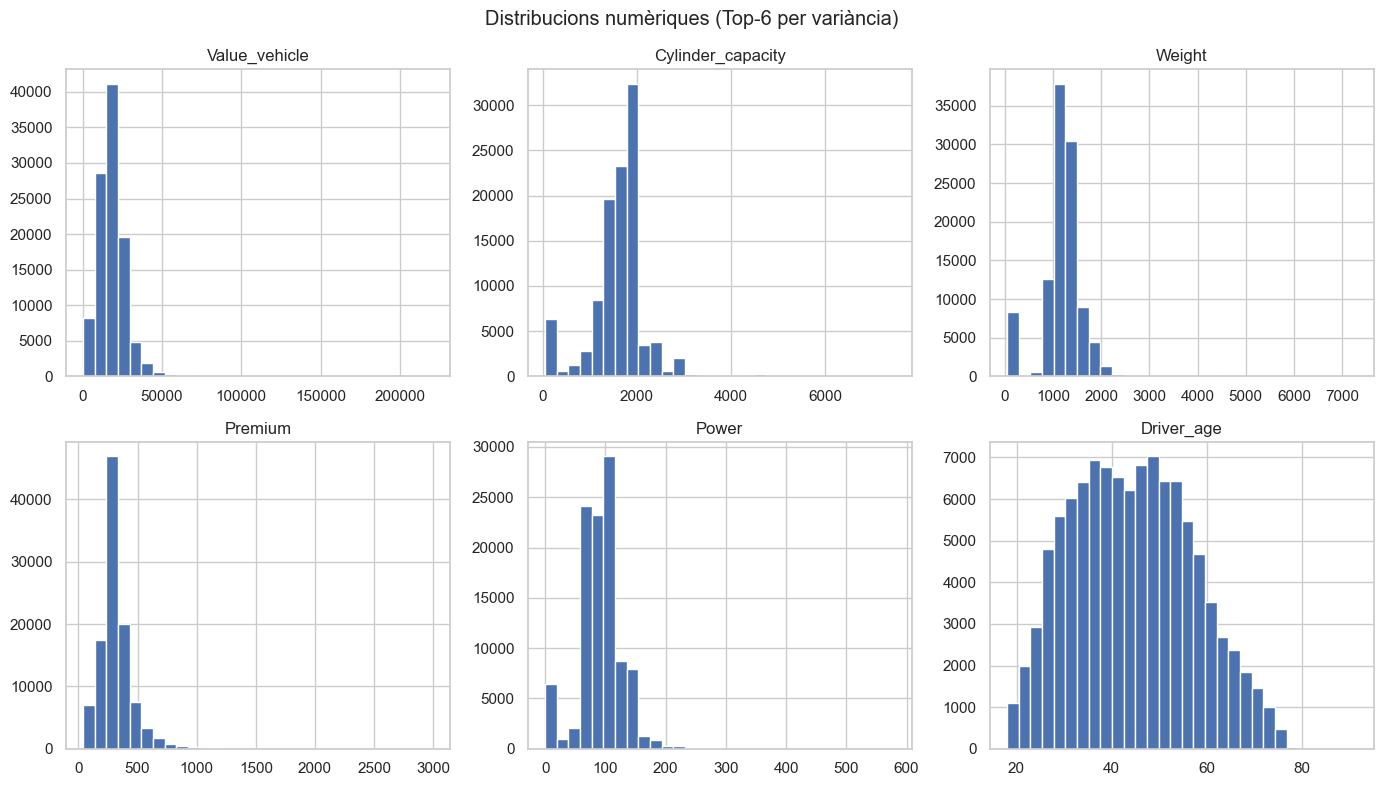


>>> Distribució de Type_risk


,count,pct
Type_risk,,
3,82990,78.62
2,13212,12.52
1,8502,8.05
4,851,0.81


Figura desada a: eda/figures\dist_Type_risk.png


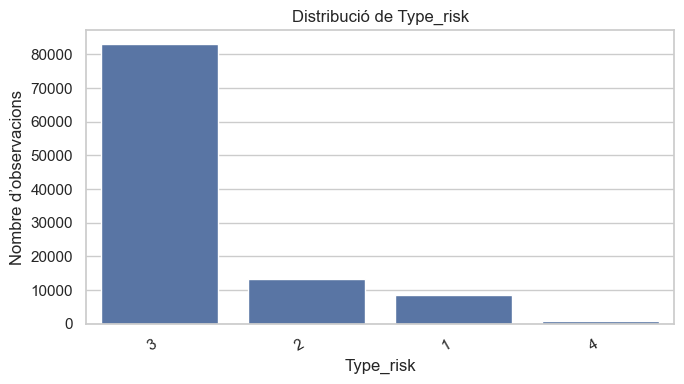


>>> Distribució de Area


,count,pct
Area,,
0,76644,72.61
1,28911,27.39


Figura desada a: eda/figures\dist_Area.png


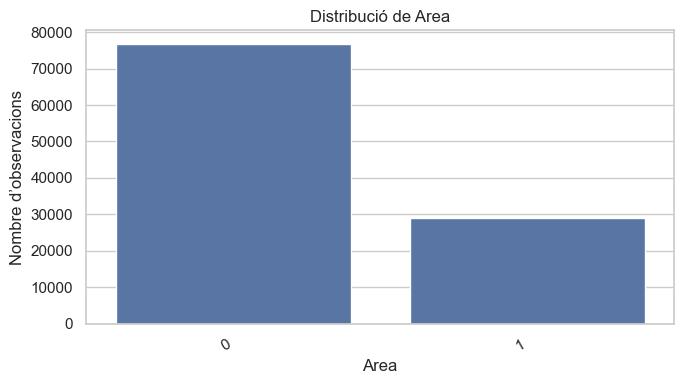


>>> Distribució de Distribution_channel


,count,pct
Distribution_channel,,
0,57917,54.87
1,47638,45.13


Figura desada a: eda/figures\dist_Distribution_channel.png


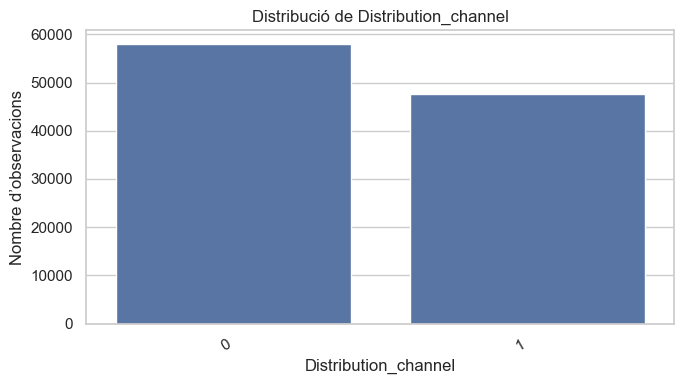


>>> Distribució de Type_fuel


,count,pct
Type_fuel,,
D,64998,61.58
P,38793,36.75
Unknown,1764,1.67


Figura desada a: eda/figures\dist_Type_fuel.png


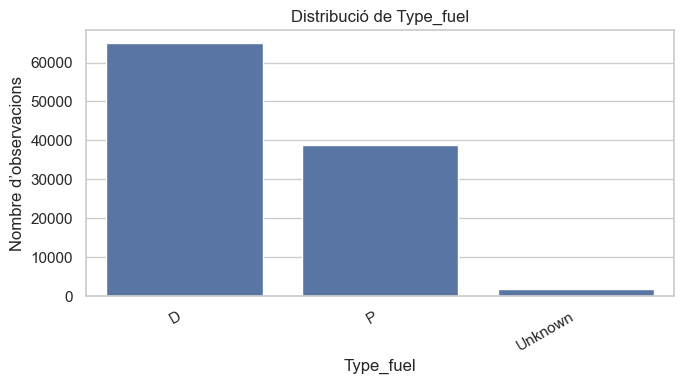


>>> Distribució de Second_driver


,count,pct
Second_driver,,
0,92497,87.63
1,13058,12.37


Figura desada a: eda/figures\dist_Second_driver.png


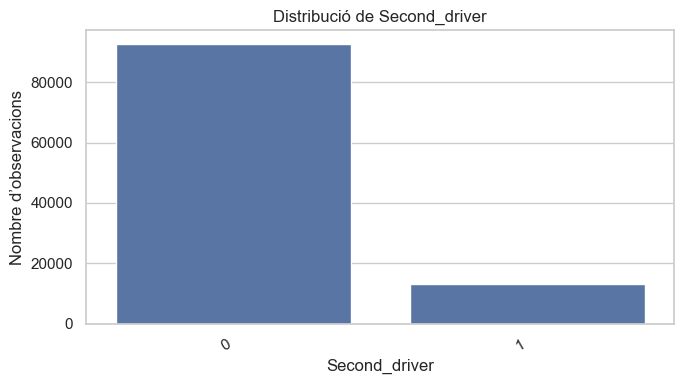


>>> Distribució de Has_lapse


,count,pct
Has_lapse,,
0,70408,66.7
1,35147,33.3


Figura desada a: eda/figures\dist_Has_lapse.png


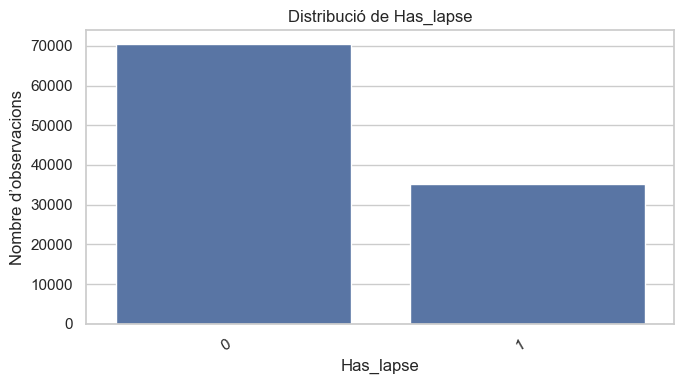


--- Diferències de mitjana per Has_claims_year ---


Has_claims_year,0,1,diff_1_minus_0
Value_vehicle,18097.780615,19794.938179,1697.157564
Cylinder_capacity,1594.606328,1719.004123,124.397795
Weight,1175.109069,1261.898605,86.789536
Premium,308.762478,347.071319,38.308841
Power,91.305416,98.704876,7.399460
N_claims_history,2.213715,5.104551,2.890836
Claims_to_premium_ratio,0.000000,2.558401,2.558401
N_claims_year,0.000000,2.120635,2.120635
R_Claims_history,0.228294,1.286210,1.057916
Vehicle_age,9.134701,9.726713,0.592012


Figura desada a: eda/figures\scatter_Value_vehicle_vs_Premium.png


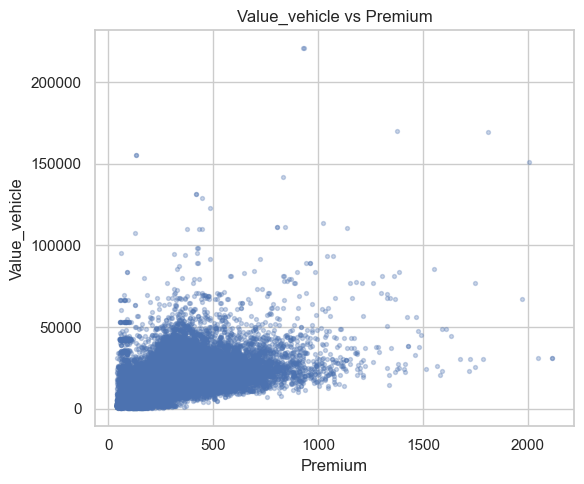

Figura desada a: eda/figures\scatter_Value_vehicle_vs_Vehicle_age.png


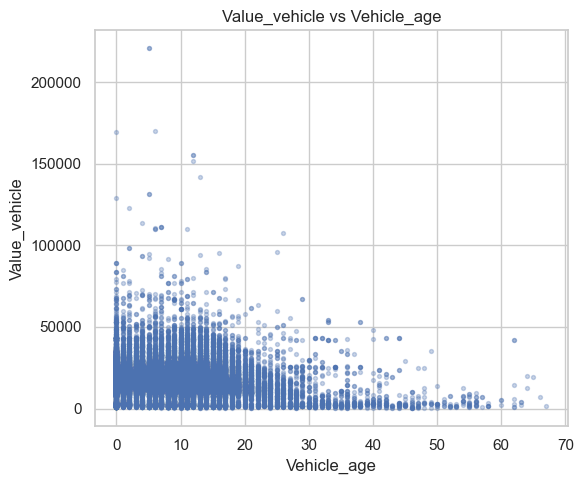


--- Resum d'outliers (IQR i z-score) per variables clau ---


,iqr_outliers_pct,z_gt3_pct
variable,,
Claims_to_premium_ratio,18.61,0.45
Cost_claims_year,18.61,0.47
Power,9.18,0.78
Premium,6.99,1.63
Value_vehicle,3.17,1.09
Length,2.16,1.15
Vehicle_age,2.01,1.32
Driver_age,0.00,0.01


Figura desada a: eda/figures\boxplot_Claims_to_premium_ratio.png


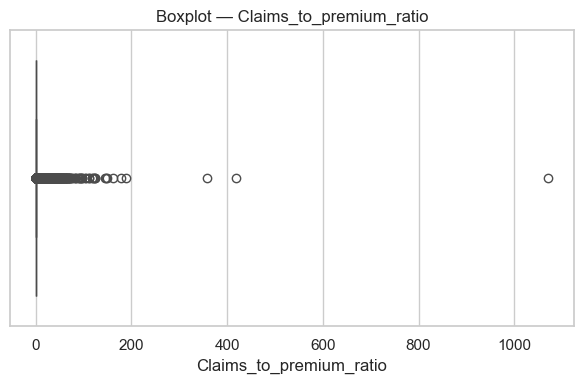

Figura desada a: eda/figures\boxplot_Cost_claims_year.png


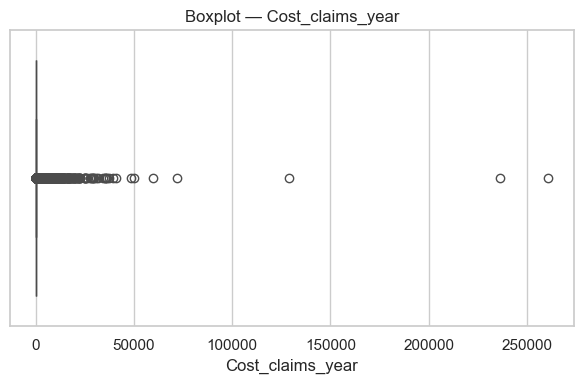

Figura desada a: eda/figures\boxplot_Driver_age.png


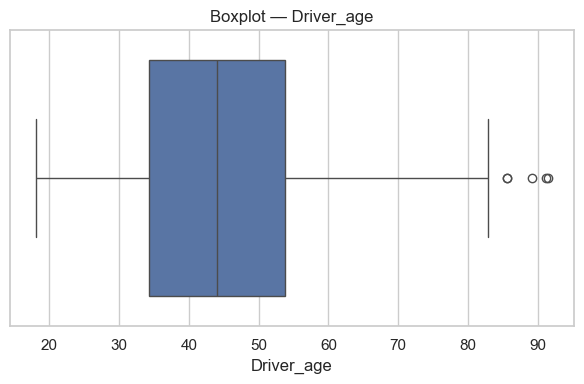

Figura desada a: eda/figures\boxplot_Length_imputed.png


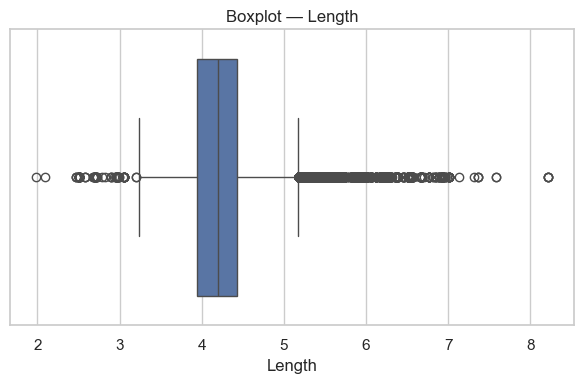

Figura desada a: eda/figures\boxplot_Power.png


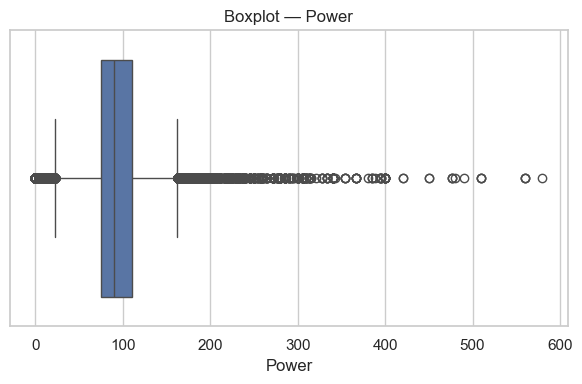

Figura desada a: eda/figures\boxplot_Premium.png


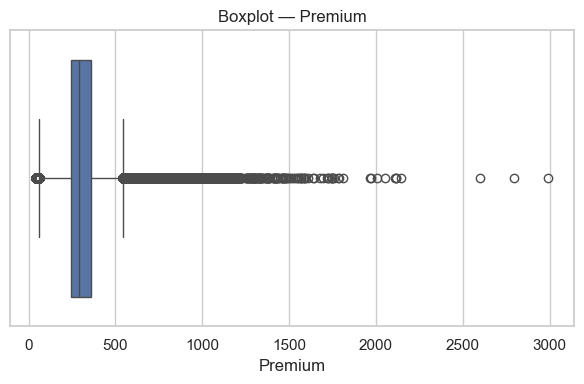

Figura desada a: eda/figures\boxplot_Value_vehicle.png


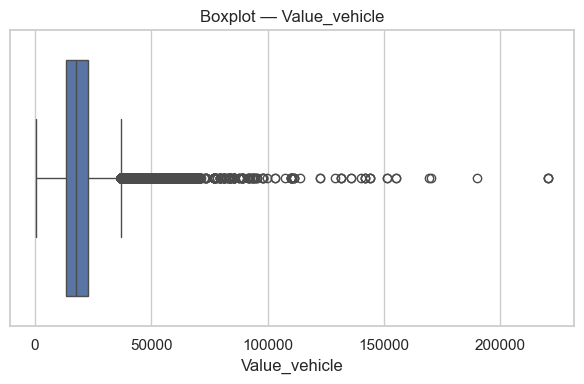

Figura desada a: eda/figures\boxplot_Vehicle_age.png


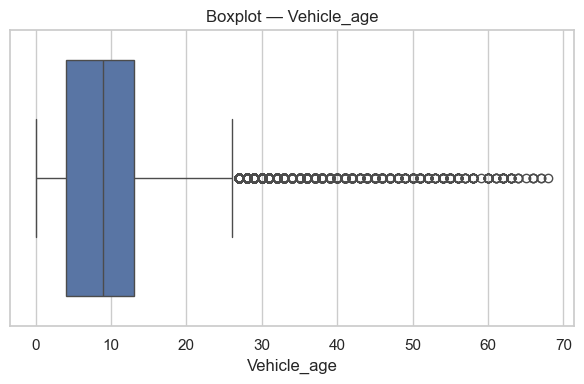

Figura desada a: eda/figures\boxplot_economic_overview.png


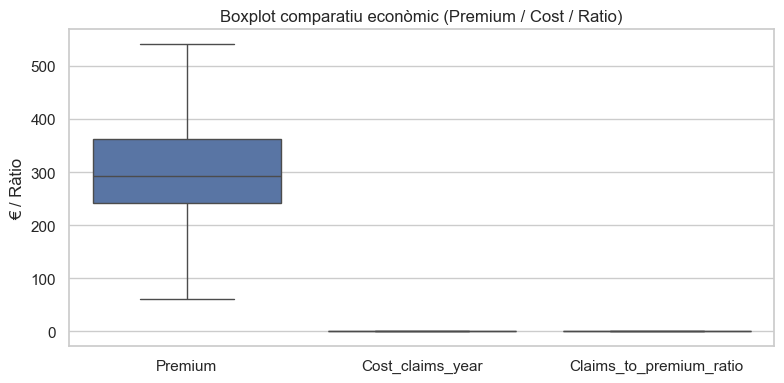


--- Matriu de correlacions (Pearson) ---


,Driver_age,Licence_age,Vehicle_age,Policy_age,Days_to_next,Has_lapse,Licence_incoherent_flag,Policy_incoherent_flag,Lapse_incoherent_flag,Length_missing_flag,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Length,Weight,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Type_risk,Area,Second_driver,Premium,N_claims_year,N_claims_history,R_Claims_history,Has_claims_history,Claims_to_premium_ratio,Payment,Lapse,Has_claims_year,Cost_claims_year
Driver_age,1.000000,0.829523,0.150581,-0.134194,-0.026729,-0.067144,-0.024174,0.000137,-0.015253,0.036525,-0.074828,-0.033358,0.018509,0.010617,-0.001502,0.024743,0.018634,0.015901,-0.014112,0.082558,0.086839,0.062725,-0.050103,-0.034846,0.118534,-0.096606,-0.006815,-0.016005,-0.034860,-0.065148,-0.004777,-0.085659,-0.023041,-0.016233,-0.011104
Licence_age,0.829523,1.000000,0.014916,0.188890,-0.020716,-0.087347,-0.033997,-0.005506,-0.006247,0.049592,-0.120770,-0.035787,0.046630,0.016601,-0.030849,0.037628,0.047457,-0.062038,0.223758,0.060945,0.111189,0.107189,-0.047673,-0.040104,0.094475,-0.114329,-0.050960,0.060909,-0.087625,0.012784,-0.021094,-0.161054,-0.032874,-0.069783,-0.026571
Vehicle_age,0.150581,0.014916,1.000000,-0.367971,-0.034946,0.045683,0.000186,0.013284,0.008629,0.202983,-0.831054,-0.227373,-0.033482,-0.163823,-0.223673,-0.092411,-0.139360,0.037851,-0.268145,0.220028,0.136474,0.109504,-0.155327,-0.011806,0.000045,-0.257943,0.036532,-0.094823,0.053144,-0.125761,0.008087,0.040191,0.088825,0.032231,-0.001694
Policy_age,-0.134194,0.188890,-0.367971,1.000000,0.012011,-0.027126,-0.009361,-0.019295,0.021610,-0.004036,-0.196511,-0.060935,0.077760,-0.060475,-0.036008,-0.014129,0.056267,-0.190001,0.681018,-0.141507,-0.012585,0.075309,0.052932,0.002320,-0.095164,-0.065145,-0.112869,0.203042,-0.114241,0.217064,-0.038055,-0.151413,-0.013488,-0.136041,-0.036761
Days_to_next,-0.026729,-0.020716,-0.034946,0.012011,1.000000,0.158884,0.004432,-0.002616,-0.013300,-0.028266,-0.036576,0.009377,0.034314,0.001786,0.015773,0.018601,0.023759,0.013901,0.032957,-0.048961,-0.025688,-0.002340,0.025111,0.018238,-0.025935,0.002426,0.090505,0.016500,0.018328,0.034371,0.021659,0.002977,0.028910,0.092077,0.022952
Has_lapse,-0.067144,-0.087347,0.045683,-0.027126,0.158884,1.000000,-0.002724,-0.006055,0.087731,-0.007461,-0.077618,0.002510,0.031238,-0.023344,-0.015323,-0.001456,-0.004866,0.118476,-0.104260,-0.046783,-0.024080,-0.016977,0.007054,0.061999,-0.036814,0.086017,0.067504,0.045164,0.180396,0.079599,0.041666,0.064159,0.562437,0.060348,0.046773
Licence_incoherent_flag,-0.024174,-0.033997,0.000186,-0.009361,0.004432,-0.002724,1.000000,0.021355,-0.001062,0.020407,0.004366,-0.012177,-0.015286,-0.009179,-0.017593,-0.011804,-0.016153,-0.003323,-0.000052,0.003499,-0.000457,0.001980,-0.018323,0.016749,-0.003081,-0.003843,0.001884,-0.004744,0.000626,0.000869,0.002626,-0.004619,-0.004611,0.006009,0.001311
Policy_incoherent_flag,0.000137,-0.005506,0.013284,-0.019295,-0.002616,-0.006055,0.021355,1.000000,-0.001574,-0.000822,-0.001021,0.001892,0.004787,0.004648,-0.001881,0.004818,0.002110,-0.004269,-0.001751,0.037005,0.023933,0.004911,-0.000050,0.000314,0.001801,-0.013409,0.003095,0.003740,-0.002597,0.002021,0.000879,-0.009375,-0.000871,0.005126,0.000777
Lapse_incoherent_flag,-0.015253,-0.006247,0.008629,0.021610,-0.013300,0.087731,-0.001062,-0.001574,1.000000,-0.002857,-0.021769,-0.001504,0.002099,-0.005519,-0.000957,-0.005228,-0.005224,-0.004418,0.004398,0.011389,0.012316,0.005958,0.004340,0.001839,-0.000456,0.002626,-0.022140,0.011158,0.016777,0.011305,-0.006252,0.015157,-0.019678,-0.029642,-0.006444
Length_missing_flag,0.036525,0.049592,0.202983,-0.004036,-0.028266,-0.007461,0.020407,-0.000822,-0.002857,1.000000,-0.209788,-0.546266,-0.508871,-0.378132,-0.792951,-0.441704,-0.501343,-0.045082,0.020004,0.117717,0.109609,0.200847,-0.703047,0.025592,-0.115803,-0.379956,-0.067487,-0.089899,-0.105755,-0.147591,-0.015196,-0.183710,0.012597,-0.088024,-0.024617


Figura desada a: eda/figures\eda_corr_matrix.png


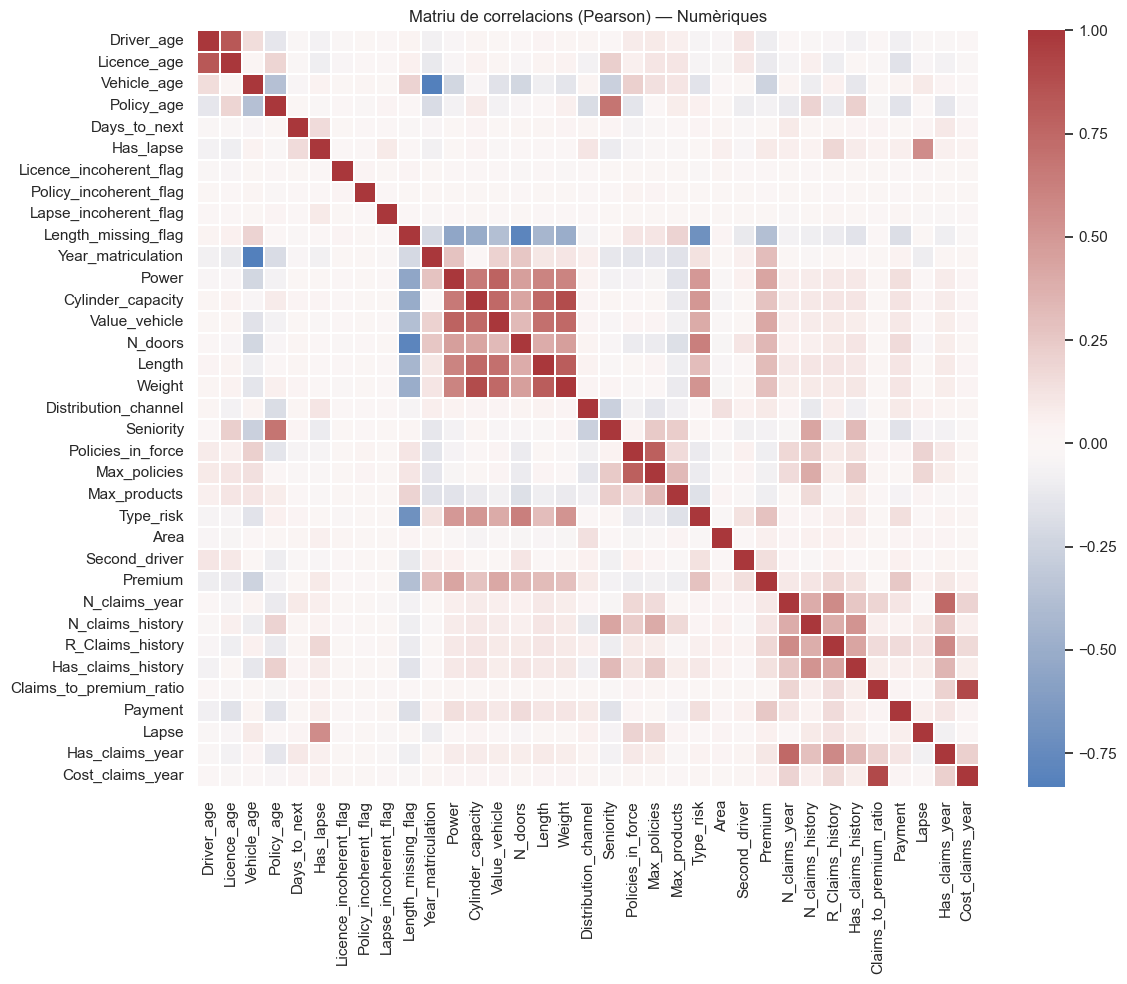


--- Top correlacions fortes (|rho| > 0.5) ---


,var1,var2,abs_corr
588,Claims_to_premium_ratio,Cost_claims_year,0.902221
345,Cylinder_capacity,Weight,0.886488
74,Vehicle_age,Year_matriculation,0.831054
0,Driver_age,Licence_age,0.829523
405,Length,Weight,0.803927
274,Length_missing_flag,N_doors,0.792951
475,Policies_in_force,Max_policies,0.790420
320,Power,Value_vehicle,0.776997
565,N_claims_year,Has_claims_year,0.746924
344,Cylinder_capacity,Length,0.745801



--- SÍNTESI EXECUTIVA 4.3.3.2 ---
Variables numèriques analitzades: 33
Variables categòriques analitzades: 6

Top-5 variables amb més outliers (IQR):


,iqr_outliers_pct,z_gt3_pct
variable,,
Claims_to_premium_ratio,18.61,0.45
Cost_claims_year,18.61,0.47
Power,9.18,0.78
Premium,6.99,1.63
Value_vehicle,3.17,1.09



4.3.3.2 COMPLET. Revisar la carpeta 'eda/figures' per veure els PNG generats.


In [6]:
# ============================================================
# 4.3.3.2 ANÀLISI DESCRIPTIVA GENERAL (EDA) — Codi complet
# ============================================================
# Objectius principals:
#   - Estadístiques descriptives de variables numèriques
#   - Distribucions de variables categòriques (baixa cardinalitat)
#   - Relacions bàsiques entre variables de negoci
#   - Detecció d’outliers (IQR, z-score) + boxplots
#   - Matriu de correlacions i heatmap
#   - Síntesi executiva final
#
# Premisses:
#   * `df` JA està carregat i tipificat correctament a 4.3.3.1
#   * Només es generen gràfics imprescindibles
#   * Es busca execució eficient (sense bucles massius innecessaris)
# ============================================================

import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats  # (en aquest codi no s’usa gaire, però és habitual per z-score, tests, etc.)

# Configuració d'opcions de display
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
# Estil per defecte dels gràfics de seaborn
sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# 0) PREPARACIÓ GENERAL
# ------------------------------------------------------------
# Carpeta on es desaran totes les figures PNG de l’EDA
os.makedirs("eda/figures", exist_ok=True)
def savefig_eda(filename, dpi=150):
    """
    Funció auxiliar per desar figures de manera consistent
    a la carpeta eda/figures.
    """
    path = os.path.join("eda/figures", filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    print(f"Figura desada a: {path}")
# Definim les variables objectiu per claredat
target_freq = "Has_claims_year"   # target del model de freqüència (binària)
target_sev  = "Cost_claims_year"  # target del model de severitat (contínua)
print("Dataset disponible per a 4.3.3.2")
print("Dimensions:", df.shape)
# Assegurem que totes les columnes numèriques són realment numèriques
# (coerció "suau": valors no convertibles → NaN)
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols_all:
    df[c] = pd.to_numeric(df[c], errors="coerce")
# Recalculem les numèriques després de la coerció
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
# Excloem identificadors i targets per tenir la llista de predictors numèrics
num_cols = [c for c in num_cols_all if c not in ["ID", target_freq, target_sev]]
# Categòriques: object o category
cat_cols_obj = df.select_dtypes(include=["object", "category"]).columns.tolist()

# ------------------------------------------------------------
# 1) ESTADÍSTIQUES DESCRIPTIVES (NUMÈRIQUES)
# ------------------------------------------------------------
# Resum estadístic ampliat amb percentils extrems i percentatge de nuls
summary = (
    df[num_cols]
    .replace([np.inf, -np.inf], np.nan)  # substituïm infinits per NaN
    .describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])  # percentils clau
    .T  # transposem per tenir variables com a files
)
summary["missing_pct"] = (df[num_cols].isna().mean() * 100).round(2)
print("\n--- Estadístiques descriptives numèriques ---")
display(summary)
# Seleccionem les 6 variables amb més variància per fer histogrames
top_vars = (
    df[num_cols].var(numeric_only=True)
      .sort_values(ascending=False)
      .head(6)
      .index.tolist()
)
# Histogrames de les top-6 variables per variància
plt.figure(figsize=(14, 8))
df[top_vars].hist(bins=30, figsize=(14, 8), layout=(2, 3))
plt.suptitle("Distribucions numèriques (Top-6 per variància)")
savefig_eda("hist_top_numeric.png")
plt.show()
plt.close("all")

# ------------------------------------------------------------
# 2) DISTRIBUCIONS CATEGÒRIQUES (incloent categòriques numèriques)
# ------------------------------------------------------------
# Variables categòriques principals d’interès
cat_core = ["Type_risk", "Area", "Distribution_channel", "Type_fuel"]
# Variables categòriques addicionals (si existeixen)
cat_extra = ["Second_driver", "Has_lapse"]
# Ens quedem només amb les que realment existeixen al df
cat_targets = [c for c in (cat_core + cat_extra) if c in df.columns]
for col in cat_targets:
    print(f"\n>>> Distribució de {col}")
    freq = df[col].value_counts(dropna=False)  # recompte per categoria (incloent NaN)
    pct  = (freq / len(df) * 100).round(2)     # percentatges
    display(pd.DataFrame({"count": freq, "pct": pct}))
    # Gràfic de barres per cada variable categòrica
    plt.figure(figsize=(7, 4))
    order = freq.index  # ordre de les categories segons freqüència
    sns.countplot(data=df, x=col, order=order)
    plt.title(f"Distribució de {col}")
    plt.xlabel(col)
    plt.ylabel("Nombre d’observacions")
    plt.xticks(rotation=30, ha="right")
    # Noms específics per a les figures mínimes requerides
    if col == "Type_risk":
        savefig_eda("dist_Type_risk.png")
    elif col == "Area":
        savefig_eda("dist_Area.png")
    elif col == "Distribution_channel":
        savefig_eda("dist_Distribution_channel.png")
    elif col == "Type_fuel":
        savefig_eda("dist_Type_fuel.png")
    elif col == "Second_driver":
        savefig_eda("dist_Second_driver.png")
    elif col == "Has_lapse":
        savefig_eda("dist_Has_lapse.png")
    plt.show()
    plt.close()

# ------------------------------------------------------------
# 3) RELACIONS BÀSIQUES
#   3.1 Diferències de mitjana per Has_claims_year (freqüència)
# ------------------------------------------------------------
print("\n--- Diferències de mitjana per Has_claims_year ---")
# Calculem la mitjana de cada variable numèrica per target=0 i target=1
mean_by_claim = df.groupby(target_freq)[num_cols].mean(numeric_only=True).T
# Afegim columna amb la diferència de mitjana (1 - 0)
mean_by_claim["diff_1_minus_0"] = (
    mean_by_claim.get(1, np.nan) - mean_by_claim.get(0, np.nan)
)
# Mostrem les 15 variables amb més diferència
display(mean_by_claim.sort_values("diff_1_minus_0", ascending=False).head(15))
#   3.2 Scatterplots clau (mínims demanats)
pairs = [
    ("Premium", "Value_vehicle"),
    ("Vehicle_age", "Value_vehicle")
]
for x, y in pairs:
    if x in df.columns and y in df.columns:
        # Seleccionem només files amb valors vàlids en ambdues variables
        sample = df[[x, y]].replace([np.inf, -np.inf], np.nan).dropna()
        # Si el conjunt és molt gran, fem un submostreig per eficiència
        if len(sample) > 50000:
            sample = sample.sample(50000, random_state=42)
        plt.figure(figsize=(6, 5))
        plt.scatter(sample[x], sample[y], s=8, alpha=0.3)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f"{y} vs {x}")
        # Desem només els scatterplots demanats explícitament
        if (x, y) == ("Premium", "Value_vehicle"):
            savefig_eda("scatter_Value_vehicle_vs_Premium.png")
        if (x, y) == ("Vehicle_age", "Value_vehicle"):
            savefig_eda("scatter_Value_vehicle_vs_Vehicle_age.png")
        plt.show()
        plt.close()

# ------------------------------------------------------------
# 4) OUTLIERS (IQR + Z-SCORE) + BOXPLOTS CLÀSSICS
# ------------------------------------------------------------
# Variables clau per a la detecció d’outliers (mínim demanat)
key_vars = [
    "Claims_to_premium_ratio",
    "Cost_claims_year",
    "Driver_age",
    "Length_imputed",   # si no existeix, la substituirem per Length
    "Power",
    "Premium",
    "Value_vehicle",
    "Vehicle_age"
]
# Si no tenim Length_imputed però sí Length, la substituïm
if "Length_imputed" not in df.columns and "Length" in df.columns:
    key_vars = [("Length" if v == "Length_imputed" else v) for v in key_vars]
# Ens quedem només amb les variables que existeixen realment al dataset
key_vars = [v for v in key_vars if v in df.columns]
def outlier_summary(series):
    """
    Calcula percentatge d’outliers per:
      - IQR (valors fora de [Q1-1.5*IQR, Q3+1.5*IQR])
      - Z-score > 3
    Retorna una Sèrie amb dos camps: iqr_outliers_pct i z_gt3_pct.
    """
    # Ens assegurem que la sèrie és numèrica i sense infinits
    s = pd.to_numeric(series.replace([np.inf, -np.inf], np.nan), errors="coerce").dropna()
    if s.empty:
        return pd.Series({"iqr_outliers_pct": np.nan, "z_gt3_pct": np.nan})
    # Càlcul IQR
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    iqr_outliers = ((s < low) | (s > high)).mean() * 100  # percentatge

    # Càlcul Z-score > 3
    std = s.std(ddof=0)
    if std == 0 or np.isnan(std):
        z_gt3 = 0.0
    else:
        z = np.abs((s - s.mean()) / std)
        z_gt3 = (z > 3).mean() * 100

    return pd.Series({
        "iqr_outliers_pct": round(iqr_outliers, 2),
        "z_gt3_pct": round(z_gt3, 2)
    })
print("\n--- Resum d'outliers (IQR i z-score) per variables clau ---")
# Construïm taula d’outliers per a totes les variables clau
out_table = pd.DataFrame({
    v: outlier_summary(df[v]) for v in key_vars
}).T
out_table.index.name = "variable"
display(out_table.sort_values("iqr_outliers_pct", ascending=False))
# Boxplots individuals per a les variables clau
for v in key_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[v].replace([np.inf, -np.inf], np.nan), orient="h")
    plt.title(f"Boxplot — {v}")
    plt.xlabel(v)
    # Noms concrets de fitxer segons variable
    if v == "Claims_to_premium_ratio":
        savefig_eda("boxplot_Claims_to_premium_ratio.png")
    elif v == "Cost_claims_year":
        savefig_eda("boxplot_Cost_claims_year.png")
    elif v == "Driver_age":
        savefig_eda("boxplot_Driver_age.png")
    elif v in ["Length_imputed", "Length"]:
        savefig_eda("boxplot_Length_imputed.png")
    elif v == "Power":
        savefig_eda("boxplot_Power.png")
    elif v == "Premium":
        savefig_eda("boxplot_Premium.png")
    elif v == "Value_vehicle":
        savefig_eda("boxplot_Value_vehicle.png")
    elif v == "Vehicle_age":
        savefig_eda("boxplot_Vehicle_age.png")
    plt.show()
    plt.close()
# Boxplot extra de Driver_age si per alguna raó no està a key_vars
if "Driver_age" in df.columns and "Driver_age" not in key_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df["Driver_age"], orient="h")
    plt.title("Boxplot — Driver_age")
    savefig_eda("boxplot_Driver_age.png")
    plt.show()
    plt.close()

# ------------------------------------------------------------
# 4.b) BOXPLOT ECONOMIC OVERVIEW (mínim demanat)
#     Comparació Premium vs Cost_claims_year vs Ratio
# ------------------------------------------------------------
# Variables econòmiques clau (si existeixen)
econ_vars = [v for v in ["Premium", "Cost_claims_year", "Claims_to_premium_ratio"] if v in df.columns]
# Transformem de format wide a long per fer un boxplot comparatiu
econ_long = df[econ_vars].copy().replace([np.inf, -np.inf], np.nan)
econ_long = econ_long.melt(var_name="variable", value_name="value").dropna()
plt.figure(figsize=(8, 4))
sns.boxplot(data=econ_long, x="variable", y="value", showfliers=False)
plt.title("Boxplot comparatiu econòmic (Premium / Cost / Ratio)")
plt.xlabel("")
plt.ylabel("€ / Ràtio")
savefig_eda("boxplot_economic_overview.png")
plt.show()
plt.close()

# ------------------------------------------------------------
# 5) MATRIU DE CORRELACIONS + HEATMAP (mínim demanat)
# ------------------------------------------------------------
# Preparem DataFrame per a correlacions: predictors + targets
corr_df = df[num_cols + [target_freq, target_sev]].replace([np.inf, -np.inf], np.nan)
# Matriu de correlacions de Pearson (amb mínim de 100 observacions per parell)
corr = corr_df.corr(method="pearson", min_periods=100)
print("\n--- Matriu de correlacions (Pearson) ---")
display(corr)
# Heatmap de la matriu de correlacions
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="vlag", center=0, square=False, linewidths=0.3)
plt.title("Matriu de correlacions (Pearson) — Numèriques")
savefig_eda("eda_corr_matrix.png")
plt.show()
plt.close()
# Paretlles de variables amb correlació absoluta més alta
corr_pairs = (
    corr.abs()
      .where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # només triangular superior
      .stack()
      .reset_index()
      .rename(columns={"level_0": "var1", "level_1": "var2", 0: "abs_corr"})
      .sort_values("abs_corr", ascending=False)
)
print("\n--- Top correlacions fortes (|rho| > 0.5) ---")
display(corr_pairs[corr_pairs["abs_corr"] > 0.5].head(20))

# ------------------------------------------------------------
# 6) SÍNTESI EXECUTIVA
# ------------------------------------------------------------
print("\n--- SÍNTESI EXECUTIVA 4.3.3.2 ---")
print(f"Variables numèriques analitzades: {len(num_cols)}")
print(f"Variables categòriques analitzades: {len(cat_targets)}")
print("\nTop-5 variables amb més outliers (IQR):")
display(out_table.sort_values("iqr_outliers_pct", ascending=False).head(5))
print("\n4.3.3.2 COMPLET. Revisar la carpeta 'eda/figures' per veure els PNG generats.")


#### <b>4.3.3.3	Anàlisi de freqüència (target: Has_claims_year)</b>

Inici 4.3.3.3 - Freqüència
Dimensions: (105555, 44)

--- Distribució de Has_claims_year ---


,count,pct
Has_claims_year,,
0,85909,81.39
1,19646,18.61


🖼️ Figura desada a: eda/figures\freq_target_distribution.png


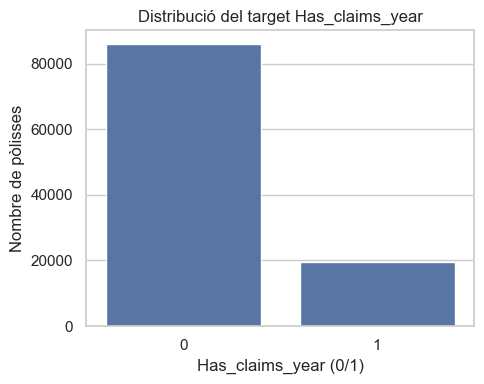


Desequilibri (0/1): 4.37 : 1

--- Taxa de sinistre per Type_risk ---


,claim_rate,count
Type_risk,,
2,0.228050,13212
3,0.192650,82990
1,0.075747,8502
4,0.001175,851


🖼️ Figura desada a: eda/figures\freq_Type_risk.png


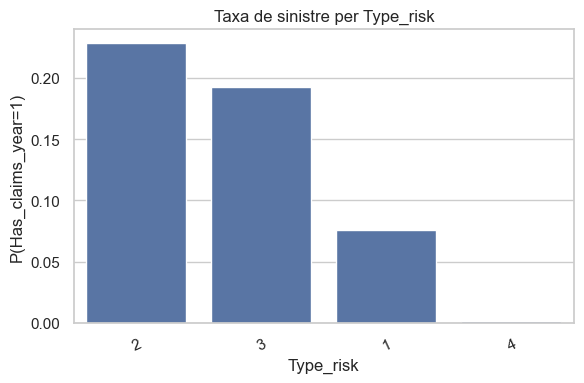


--- Taxa de sinistre per Area ---


,claim_rate,count
Area,,
1,0.204248,28911
0,0.179283,76644


🖼️ Figura desada a: eda/figures\freq_Area.png


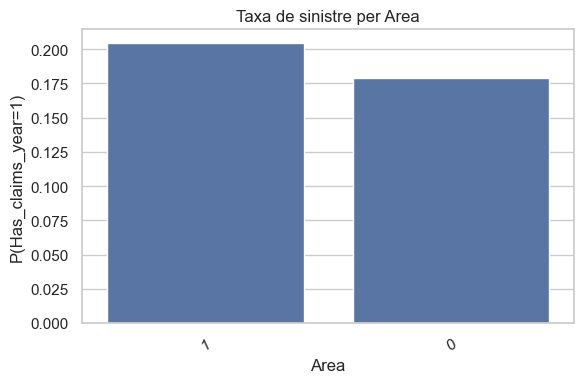


--- Taxa de sinistre per Type_fuel ---


,claim_rate,count
Type_fuel,,
D,0.208468,64998
P,0.153352,38793
Unknown,0.083333,1764


🖼️ Figura desada a: eda/figures\freq_Type_fuel.png


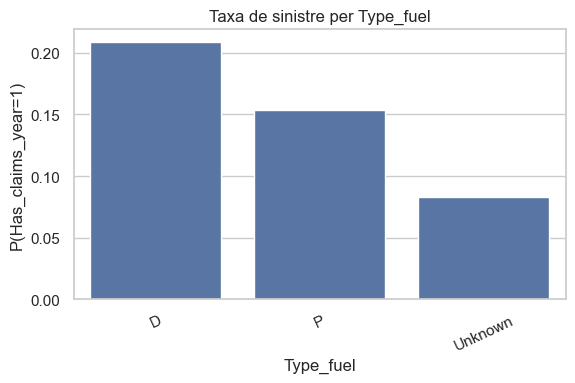


--- Taxa de sinistre per Distribution_channel ---


,claim_rate,count
Distribution_channel,,
1,0.203010,47638
0,0.172229,57917


🖼️ Figura desada a: eda/figures\freq_Distribution_channel.png


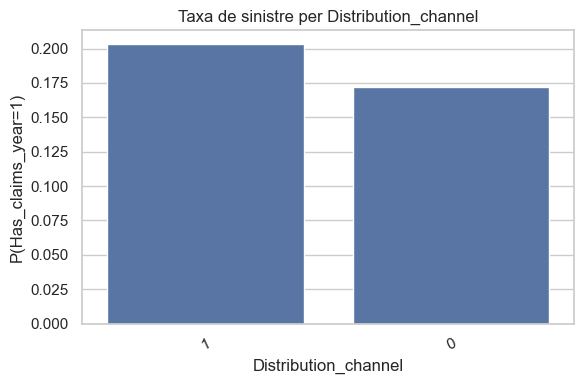


--- Taxa de sinistre per Has_lapse ---


,claim_rate,count
Has_lapse,,
1,0.219364,35147
0,0.169526,70408


🖼️ Figura desada a: eda/figures\freq_Has_lapse.png


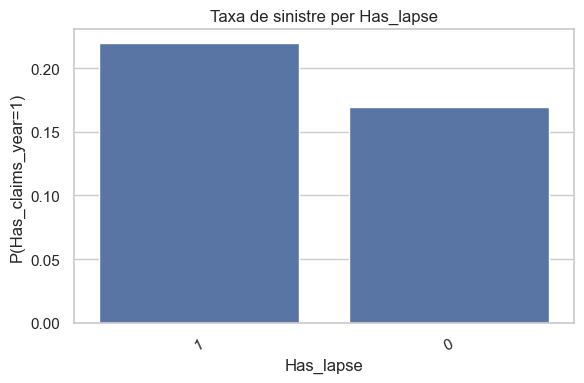


--- Taxa de sinistre per Second_driver ---


,claim_rate,count
Second_driver,,
1,0.227217,13058
0,0.180319,92497


🖼️ Figura desada a: eda/figures\freq_Second_driver.png


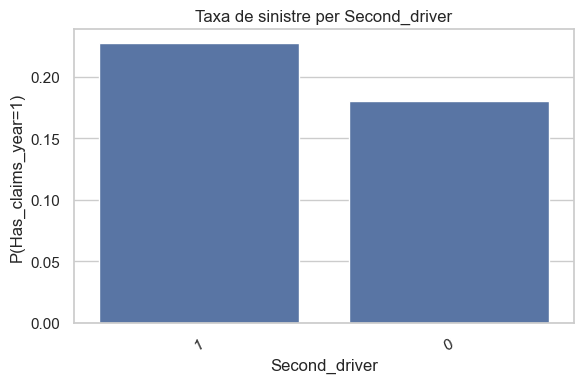


--- Second_driver vs Has_claims_year ---


,claim_rate,count
Second_driver,,
1,0.227217,13058
0,0.180319,92497


🖼️ Figura desada a: eda/figures\freq_Second_driver.png


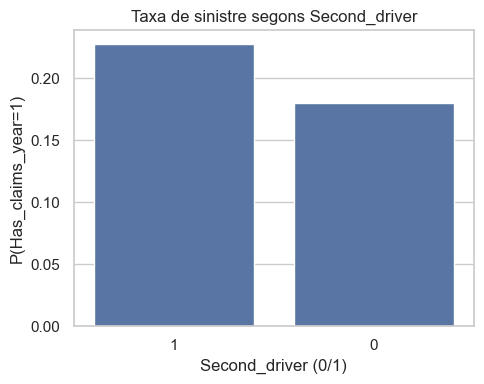


--- Boxplots numèriques vs Has_claims_year ---
🖼️ Figura desada a: eda/figures\box_Driver_age.png


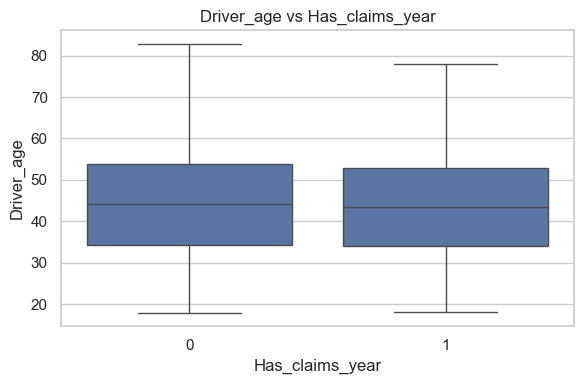

🖼️ Figura desada a: eda/figures\box_Vehicle_age.png


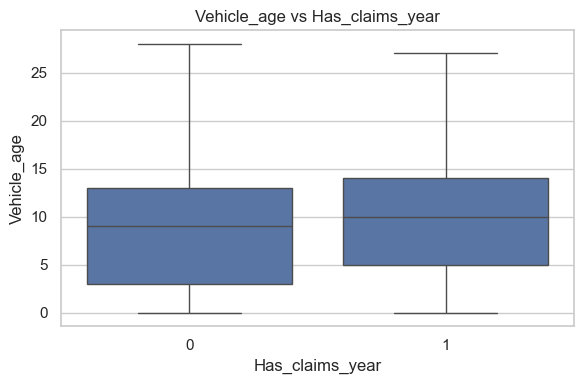

🖼️ Figura desada a: eda/figures\box_Power.png


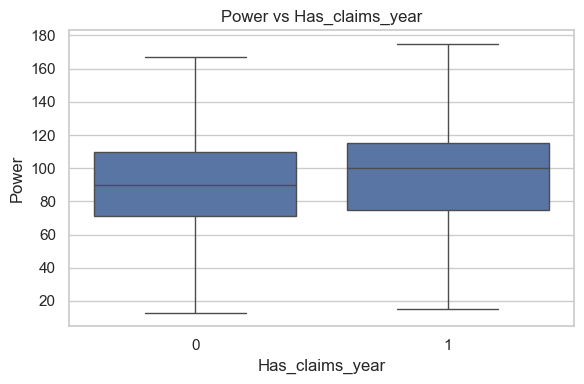

🖼️ Figura desada a: eda/figures\box_Premium.png


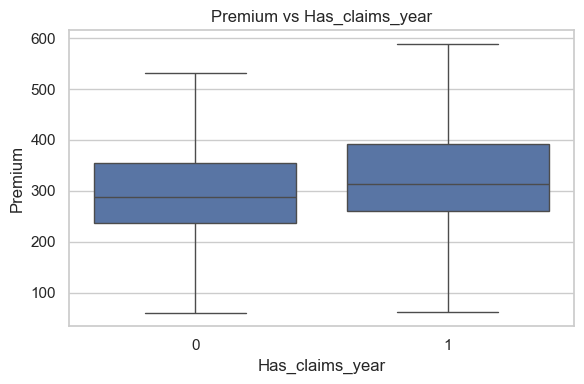

🖼️ Figura desada a: eda/figures\box_Value_vehicle.png


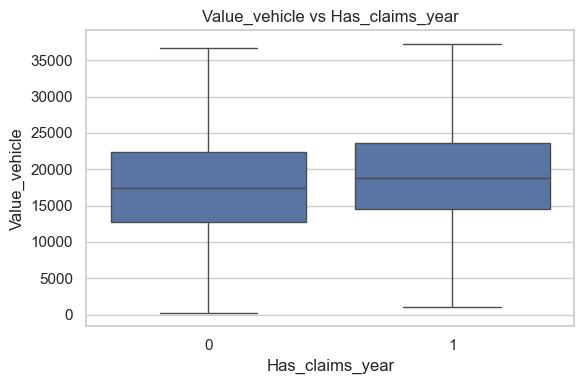

🖼️ Figura desada a: eda/figures\box_Licence_age.png


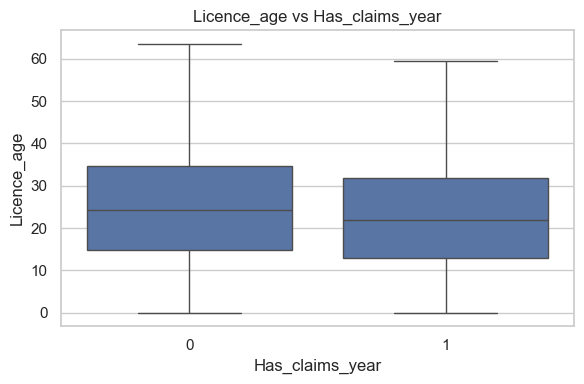

🖼️ Figura desada a: eda/figures\box_Policy_age.png


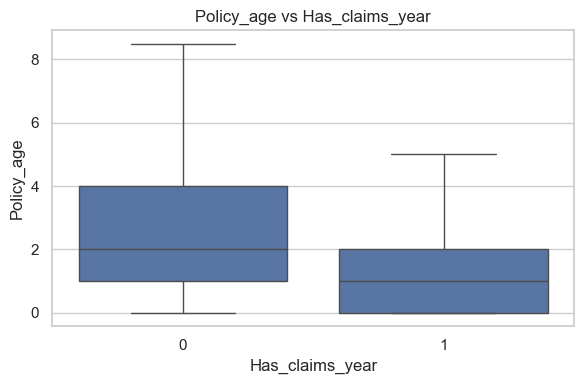

🖼️ Figura desada a: eda/figures\box_Seniority.png


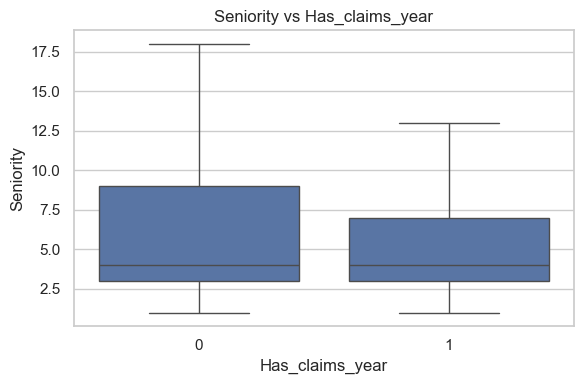

🖼️ Figura desada a: eda/figures\box_Policies_in_force.png


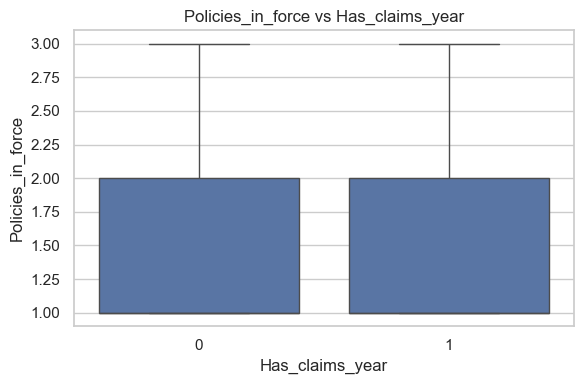


--- Correlacions point-biserial amb Has_claims_year ---


,variable,r_pointbiserial,p_value,abs_r
26,N_claims_year,0.746924,0.000000e+00,0.746924
28,R_Claims_history,0.575965,0.000000e+00,0.575965
29,Has_claims_history,0.348369,0.000000e+00,0.348369
27,N_claims_history,0.289861,0.000000e+00,0.289861
30,Claims_to_premium_ratio,0.210935,0.000000e+00,0.210935
3,Policy_age,-0.136041,0.000000e+00,0.136041
31,Payment,0.116151,9.971082e-314,0.116151
25,Premium,0.105799,2.287284e-260,0.105799
4,Days_to_next,0.092077,1.868021e-197,0.092077
19,Policies_in_force,0.092033,2.876047e-197,0.092033


🖼️ Figura desada a: eda/figures\freq_pointbiserial_corr.png


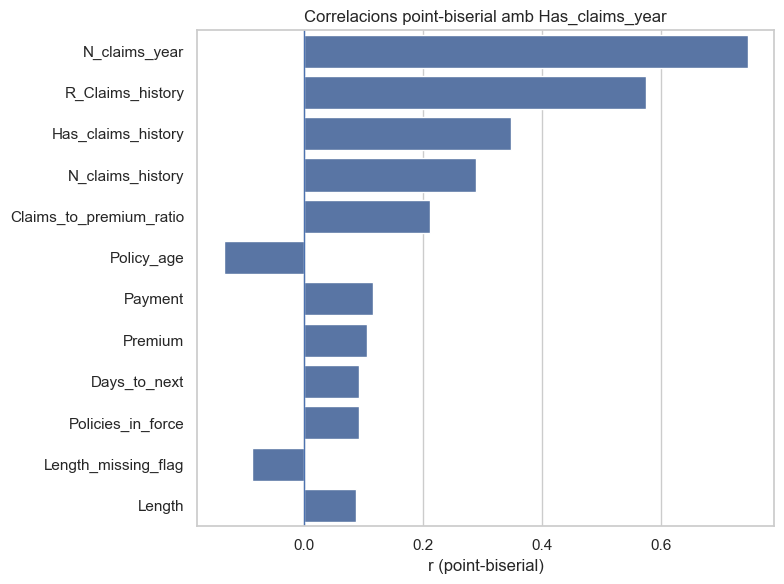

C:\Users\TpM\AppData\Local\Temp\ipykernel_7048\1137427417.py:233: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = tmp.groupby("bin")[target].mean().to_frame("claim_rate")


,claim_rate,count
bin,,
"(17.999, 25.0]",0.177081,5489
"(25.0, 35.0]",0.191735,22917
"(35.0, 45.0]",0.191172,26981
"(45.0, 55.0]",0.192675,27196
"(55.0, 65.0]",0.174042,16203
"(65.0, 80.0]",0.156976,6759
"(80.0, 120.0]",0.100000,10


🖼️ Figura desada a: eda/figures\freq_Driver_age.png


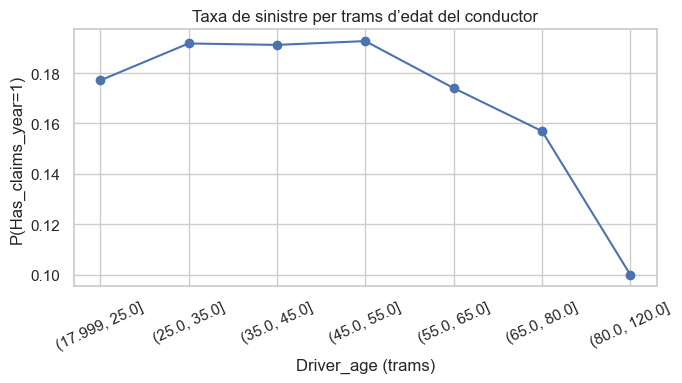

C:\Users\TpM\AppData\Local\Temp\ipykernel_7048\1137427417.py:233: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = tmp.groupby("bin")[target].mean().to_frame("claim_rate")


,claim_rate,count
bin,,
"(-0.001, 2.0]",0.144222,22195
"(2.0, 5.0]",0.168375,11314
"(5.0, 8.0]",0.177764,14463
"(8.0, 12.0]",0.206799,26238
"(12.0, 16.0]",0.221409,19665
"(16.0, 20.0]",0.223206,7231
"(20.0, 30.0]",0.159307,3057
"(30.0, 60.0]",0.062638,1357


🖼️ Figura desada a: eda/figures\freq_Vehicle_age.png


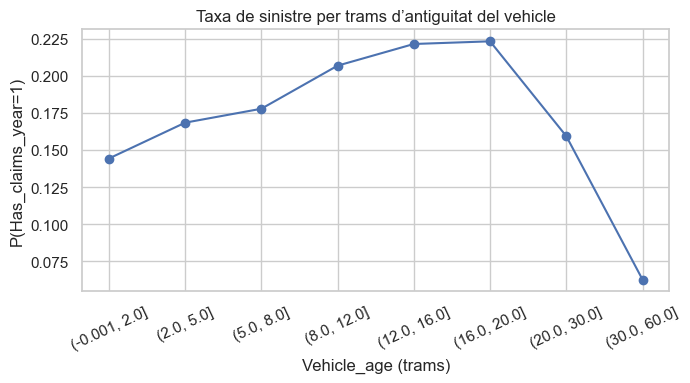

C:\Users\TpM\AppData\Local\Temp\ipykernel_7048\1137427417.py:233: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = tmp.groupby("bin")[target].mean().to_frame("claim_rate")


,claim_rate,count
bin,,
"(-0.001, 70.0]",0.137493,24074
"(70.0, 90.0]",0.189114,29617
"(90.0, 100.0]",0.193435,10541
"(100.0, 115.0]",0.207408,21571
"(115.0, 580.0]",0.213751,19752


🖼️ Figura desada a: eda/figures\freq_Power.png


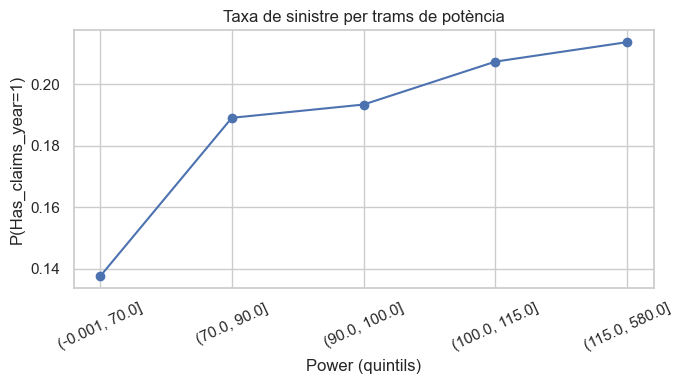


4.3.3.3 completat. Figures mínimes garantides a eda/figures


In [8]:
# ============================================================
# 4.3.3.3 ANÀLISI DE FREQÜÈNCIA (Has_claims_year)
# ============================================================
# Objectiu:
#   - Analitzar la variable objectiu de freqüència **Has_claims_year**:
#        * Distribució i desequilibri de classes.
#        * Taxa de sinistre per factors categòrics clau.
#        * Anàlisi específica de **Second_driver**.
#        * Relacions bivariants amb predictors numèrics (boxplots).
#        * Correlacions binàries (point-biserial) amb variables numèriques.
#   - Generar un conjunt mínim de figures interpretables per al TFM,
#     incloent com a mínim les 14 figures demanades.
#
# Premisses:
#   - S'assumeix que **df** ja està carregat i tipificat correctament
#     a la fase 4.3.3.1 (EDA inicial).
#   - No es fan transformacions avançades ni codificació one-hot.
#   - No s’eliminen outliers: només diagnòstic exploratori.
# ============================================================

from scipy.stats import pointbiserialr  # import

# Opcions de display per veure millor el DataFrame
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
# Estil visual per defecte dels gràfics
sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# 0) Preparació general
# ------------------------------------------------------------
# Creem carpeta per guardar les figures de l’EDA si no existeix
os.makedirs("eda/figures", exist_ok=True)
def savefig_freq(filename, dpi=150):
    """
    Desa la figura actual a la carpeta eda/figures amb el nom indicat.
    Utilitza tight_layout per evitar retalls de títols/etiquetes.
    """
    path = os.path.join("eda/figures", filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    print(f"🖼️ Figura desada a: {path}")
# Nom de la variable target de freqüència
target = "Has_claims_year"
print("Inici 4.3.3.3 - Freqüència")
print("Dimensions:", df.shape)
# Assegurem que totes les columnes numèriques són realment numèriques
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols_all:
    # errors="coerce" converteix valors no numèrics a NaN
    df[c] = pd.to_numeric(df[c], errors="coerce")
# Llista de predictors numèrics:
#   - excloem ID (identificador) i els targets (freqüència i severitat)
num_cols = [c for c in num_cols_all if c not in ["ID", target, "Cost_claims_year"]]

# ------------------------------------------------------------
# 1) DISTRIBUCIÓ I DESEQUILIBRI DEL TARGET
# ------------------------------------------------------------
print("\n--- Distribució de Has_claims_year ---")
# Recompte de 0/1 i (si n’hi ha) NaN
target_counts = df[target].value_counts(dropna=False)
# Percentatge respecte el total de registres
target_pct = (target_counts / len(df) * 100).round(2)
display(pd.DataFrame({"count": target_counts, "pct": target_pct}))
# Gràfic de barres per visualitzar el desequilibri de classes
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x=target, order=target_counts.index)
plt.title("Distribució del target Has_claims_year")
plt.xlabel("Has_claims_year (0/1)")
plt.ylabel("Nombre de pòlisses")
savefig_freq("freq_target_distribution.png")   # FIGURA 1 requerida
plt.show()
plt.close()
# Càlcul ràtio de desequilibri 0/1 (classe sense sinistre / amb sinistre)
imbalance_ratio = target_counts.get(0, np.nan) / max(target_counts.get(1, 1), 1)
print(f"\nDesequilibri (0/1): {imbalance_ratio:.2f} : 1")

# ------------------------------------------------------------
# 2) FREQÜÈNCIA PER FACTORS CATEGÒRICS
#    (taxa de sinistre = P(Has_claims_year=1))
# ------------------------------------------------------------
# Factors categòrics rellevants per la freqüència
cat_factors = [
    "Type_risk", "Area", "Type_fuel",
    "Distribution_channel", "Has_lapse", "Second_driver"
]
# Ens quedem només amb els que existeixen al DataFrame
cat_factors = [c for c in cat_factors if c in df.columns]
def claim_rate_by_factor(col):
    """
    Calcula la taxa de sinistre i el nombre d’observacions per categoria
    d’un factor categòric donat.
      - claim_rate = mitjana de Has_claims_year per categoria
      - count = nombre de registres per categoria
    """
    tab = df.groupby(col)[target].mean().rename("claim_rate").to_frame()
    tab["count"] = df[col].value_counts()
    tab = tab.sort_values("claim_rate", ascending=False)
    return tab
for col in cat_factors:
    print(f"\n--- Taxa de sinistre per {col} ---")
    tab = claim_rate_by_factor(col)
    display(tab)
    # Gràfic de barres de la taxa de sinistre per categoria
    plt.figure(figsize=(6, 4))
    sns.barplot(data=tab.reset_index(), x=col, y="claim_rate", order=tab.index)
    plt.title(f"Taxa de sinistre per {col}")
    plt.ylabel("P(Has_claims_year=1)")
    plt.xlabel(col)
    plt.xticks(rotation=25)
    # Guardem figures mínimes segons el factor
    if col == "Type_risk":
        savefig_freq("freq_Type_risk.png")             # FIGURA 2 requerida
    if col == "Area":
        savefig_freq("freq_Area.png")                  # FIGURA 3 requerida
    if col == "Type_fuel":
        savefig_freq("freq_Type_fuel.png")             # FIGURA 4 requerida
    if col == "Distribution_channel":
        savefig_freq("freq_Distribution_channel.png")  # figura extra útil
    if col == "Has_lapse":
        savefig_freq("freq_Has_lapse.png")             # figura extra útil
    if col == "Second_driver":
        savefig_freq("freq_Second_driver.png")         # FIGURA 5 requerida
    plt.show()
    plt.close()

# ------------------------------------------------------------
# 3) ANÀLISI ESPECÍFICA DE Second_driver
# ------------------------------------------------------------
if "Second_driver" in df.columns:
    print("\n--- Second_driver vs Has_claims_year ---")
    tab_sd = claim_rate_by_factor("Second_driver")
    display(tab_sd)
    # Barplot específic per Second_driver
    plt.figure(figsize=(5, 4))
    sns.barplot(
        data=tab_sd.reset_index(),
        x="Second_driver",
        y="claim_rate",
        order=tab_sd.index
    )
    plt.title("Taxa de sinistre segons Second_driver")
    plt.ylabel("P(Has_claims_year=1)")
    plt.xlabel("Second_driver (0/1)")
    savefig_freq("freq_Second_driver.png")  # reforcem la generació d’aquesta figura
    plt.show()
    plt.close()

# ------------------------------------------------------------
# 4) BIVARIANT: BOXPLOTS NUMÈRIQUES vs TARGET
#    (mínim requerit: Driver_age, Vehicle_age, Power, Premium, Value_vehicle)
# ------------------------------------------------------------
box_vars_required = ["Driver_age", "Vehicle_age", "Power", "Premium", "Value_vehicle"]
# Filtrar només les variables que existeixen al DataFrame
box_vars_required = [v for v in box_vars_required if v in df.columns]
print("\n--- Boxplots numèriques vs Has_claims_year ---")
for v in box_vars_required:
    plt.figure(figsize=(6, 4))
    # Boxplot de la distribució de v per cada valor del target
    sns.boxplot(data=df, x=target, y=v, showfliers=False)
    plt.title(f"{v} vs Has_claims_year")
    plt.xlabel("Has_claims_year")
    plt.ylabel(v)
    # Guardem figures amb noms concrets per cada variable requerida
    if v == "Driver_age":
        savefig_freq("box_Driver_age.png")       # FIGURA 6 requerida
    if v == "Vehicle_age":
        savefig_freq("box_Vehicle_age.png")      # FIGURA 7 requerida
    if v == "Power":
        savefig_freq("box_Power.png")            # FIGURA 8 requerida
    if v == "Premium":
        savefig_freq("box_Premium.png")          # FIGURA 9 requerida
    if v == "Value_vehicle":
        savefig_freq("box_Value_vehicle.png")    # FIGURA 10 requerida
    plt.show()
    plt.close()

# Boxplots addicionals per altres predictors numèrics rellevants (si existeixen)
extra_box_vars = ["Licence_age", "Policy_age", "Seniority", "Policies_in_force"]
extra_box_vars = [v for v in extra_box_vars if v in df.columns]
for v in extra_box_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x=target, y=v, showfliers=False)
    plt.title(f"{v} vs Has_claims_year")
    plt.xlabel("Has_claims_year")
    plt.ylabel(v)
    savefig_freq(f"box_{v}.png")   # guardem amb un nom genèric
    plt.show()
    plt.close()

# ------------------------------------------------------------
# 5) CORRELACIONS BINÀRIES (point-biserial) amb predictors numèrics
# ------------------------------------------------------------
print("\n--- Correlacions point-biserial amb Has_claims_year ---")
pb_rows = []
for v in num_cols:
    # Eliminem files amb NaN en la variable o el target
    s = df[[v, target]].dropna()
    # Si la variable numèrica no té variabilitat (un sol valor), no té sentit calcular correlació
    if s[v].nunique() <= 1:
        continue
    # pointbiserialr calcula correlació entre binària (target) i contínua (v)
    r, p = pointbiserialr(s[target], s[v])
    pb_rows.append([v, r, p])
# Construïm DataFrame amb resultats de correlació
pb_df = pd.DataFrame(pb_rows, columns=["variable", "r_pointbiserial", "p_value"])
pb_df["abs_r"] = pb_df["r_pointbiserial"].abs()
pb_df = pb_df.sort_values("abs_r", ascending=False)
display(pb_df.head(15))

# Gràfic barplot amb les 12 variables més correlacionades amb el target
plt.figure(figsize=(8, 6))
sns.barplot(data=pb_df.head(12), y="variable", x="r_pointbiserial")
plt.axvline(0, lw=1)
plt.title("Correlacions point-biserial amb Has_claims_year")
plt.xlabel("r (point-biserial)")
plt.ylabel("")
savefig_freq("freq_pointbiserial_corr.png")  # FIGURA 11 requerida
plt.show()
plt.close()

# ------------------------------------------------------------
# 6) FREQÜÈNCIA PER TRAMS (NUMÈRIQUES CLAU)
#    (Driver_age, Vehicle_age, Power)
# ------------------------------------------------------------
def binned_claim_rate(var, bins, labels=None):
    """
    Crea trams (bins) per a una variable numèrica i calcula
    la taxa de sinistre i el recompte per a cada tram.
    """
    tmp = df[[var, target]].dropna().copy()
    tmp["bin"] = pd.cut(tmp[var], bins=bins, labels=labels, include_lowest=True)
    tab = tmp.groupby("bin")[target].mean().to_frame("claim_rate")
    tab["count"] = tmp["bin"].value_counts().sort_index()
    return tab
def plot_binned(tab, title, xlabel, filename):
    """
    Dibuixa una línia de la taxa de sinistre per tram
    i desa la figura amb el nom proporcionat.
    """
    tab_plot = tab.reset_index()
    tab_plot["bin_str"] = tab_plot["bin"].astype(str)

    plt.figure(figsize=(7, 4))
    plt.plot(tab_plot["bin_str"], tab_plot["claim_rate"], marker="o")
    plt.title(title)
    plt.ylabel("P(Has_claims_year=1)")
    plt.xlabel(xlabel)
    plt.xticks(rotation=25)
    savefig_freq(filename)
    plt.show()
    plt.close()
# Trams d’edat del conductor (Driver_age)
if "Driver_age" in df.columns:
    bins_age = [18, 25, 35, 45, 55, 65, 80, 120]   # intervals raonables d’edat
    tab_age = binned_claim_rate("Driver_age", bins_age)
    display(tab_age)

    plot_binned(
        tab_age,
        title="Taxa de sinistre per trams d’edat del conductor",
        xlabel="Driver_age (trams)",
        filename="freq_Driver_age.png"    # FIGURA 12 requerida (freq per trams d’edat)
    )
# Trams d’antiguitat del vehicle (Vehicle_age)
if "Vehicle_age" in df.columns:
    bins_vage = [0, 2, 5, 8, 12, 16, 20, 30, 60]
    tab_vage = binned_claim_rate("Vehicle_age", bins_vage)
    display(tab_vage)

    plot_binned(
        tab_vage,
        title="Taxa de sinistre per trams d’antiguitat del vehicle",
        xlabel="Vehicle_age (trams)",
        filename="freq_Vehicle_age.png"   # FIGURA 13 requerida
    )
# Trams de potència (Power), definits per quintils
if "Power" in df.columns:
    # Calculem quintils i els usem com a punts de tall
    bins_pow = np.quantile(df["Power"].dropna(), [0, .2, .4, .6, .8, 1.0])
    tab_pow = binned_claim_rate("Power", bins_pow)
    display(tab_pow)

    plot_binned(
        tab_pow,
        title="Taxa de sinistre per trams de potència",
        xlabel="Power (quintils)",
        filename="freq_Power.png"         # FIGURA 14 requerida
    )
print("\n4.3.3.3 completat. Figures mínimes garantides a eda/figures")


#### <b>4.3.3.4 Anàlisi de severitat (target: Cost_claims_year, filtre Has_claims_year = 1)</b>

Inici 4.3.3.4 - Severitat
Dimensions dataset complet: (105555, 44)

--- Filtre severitat aplicat ---
Registres amb sinistre anual: 19646
Percentatge sobre total: 18.61 %

--- Estadístiques descriptives Cost_claims_year (només sinistres) ---


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Cost_claims_year,19646.0,825.040281,3342.045365,40.05,49.95,51.95,95.77,289.435,882.0,2861.9425,8301.5415,260853.24


🖼️ Figura desada a: eda/figures\sev_dist_Cost_claims_year.png


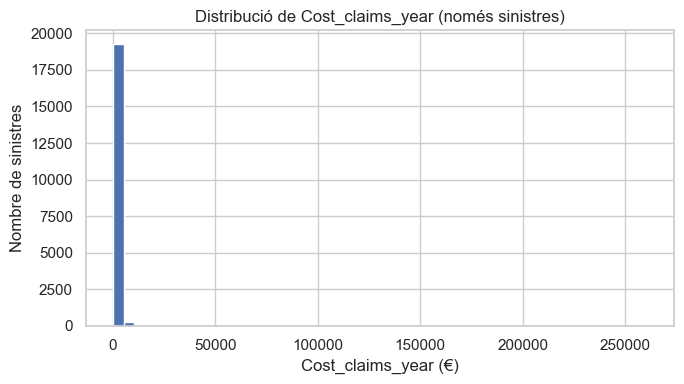

🖼️ Figura desada a: eda/figures\sev_box_Cost_claims_year.png


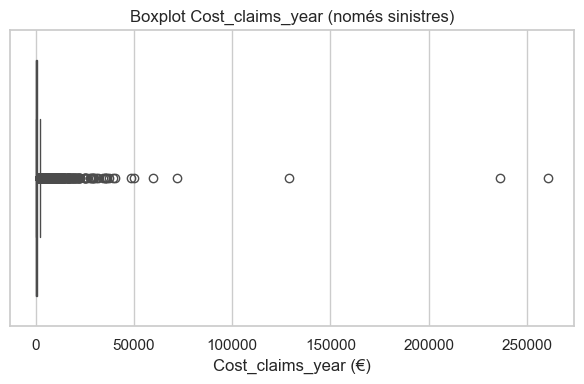

🖼️ Figura desada a: eda/figures\sev_dist_log_Cost_claims_year.png


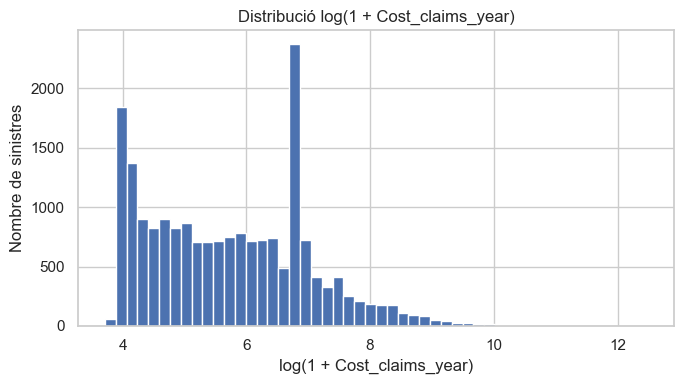


Asimetria (skewness): 47.214
Curtosi (kurtosis): 3258.274

--- Outliers Cost_claims_year ---
Llindars IQR: -1083.58 - 2061.35
Outliers IQR (%): 7.12
Outliers Z>|3| (%): 0.61

Mitjana amb outliers: 825.04
Mitjana sense outliers IQR: 434.88
Impacte relatiu outliers en la mitjana: 89.72 %
🖼️ Figura desada a: eda/figures\sev_outliers_impact.png


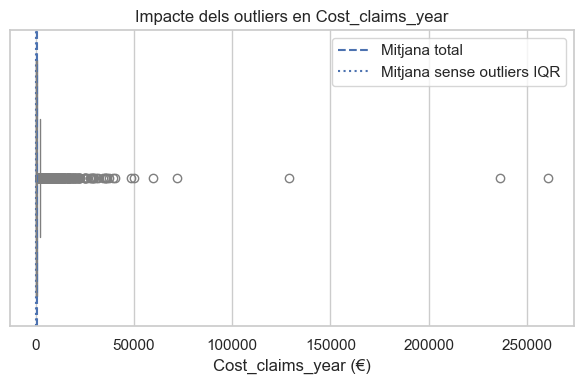


--- Severitat per Type_risk ---


,mean,median,count
Type_risk,,,
3,857.001447,298.415,15988
2,729.423604,282.320,3013
1,479.900994,141.255,644
4,192.670000,192.670,1


🖼️ Figura desada a: eda/figures\sev_box_Type_risk.png


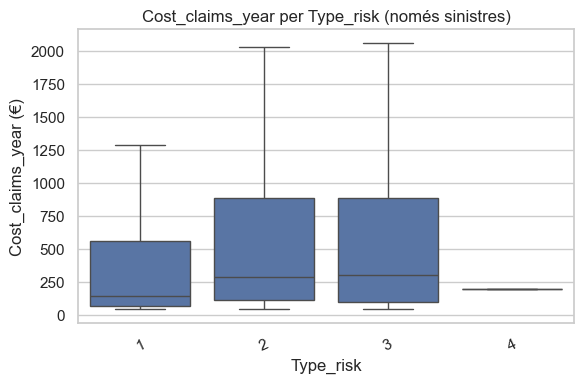


--- Severitat per Area ---


,mean,median,count
Area,,,
1,846.083041,292.29,5905
0,815.997454,287.50,13741


🖼️ Figura desada a: eda/figures\sev_box_Area.png


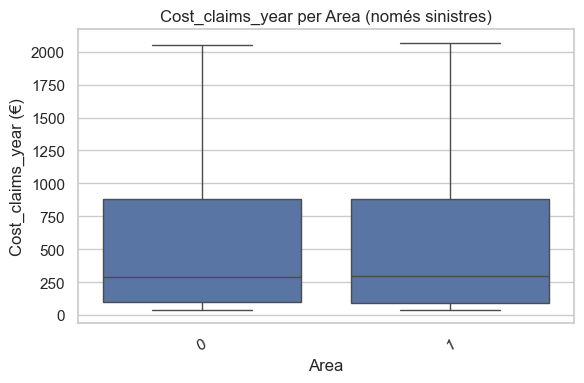


--- Severitat per Type_fuel ---


,mean,median,count
Type_fuel,,,
D,829.501027,303.11,13550
P,825.316645,262.06,5949
Unknown,402.678503,128.99,147


🖼️ Figura desada a: eda/figures\sev_box_Type_fuel.png


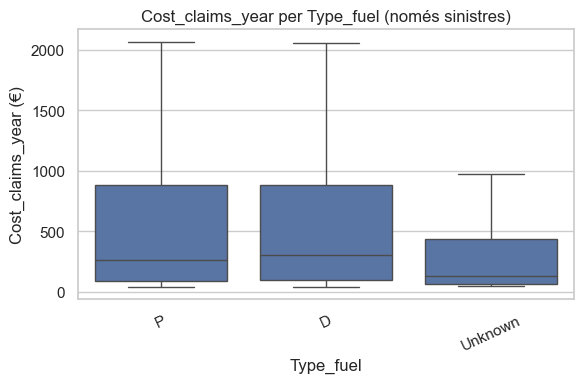


--- Severitat per Distribution_channel ---


,mean,median,count
Distribution_channel,,,
1,868.956739,300.22,9671
0,782.462231,278.23,9975


🖼️ Figura desada a: eda/figures\sev_box_Distribution_channel.png


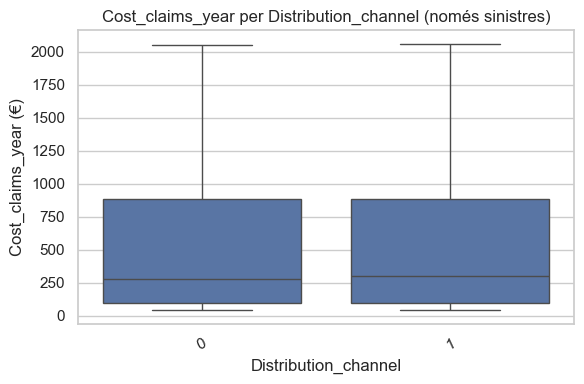


--- Severitat per Second_driver ---


,mean,median,count
Second_driver,,,
1,902.480593,331.43,2967
0,811.264551,282.85,16679


🖼️ Figura desada a: eda/figures\sev_box_Second_driver.png


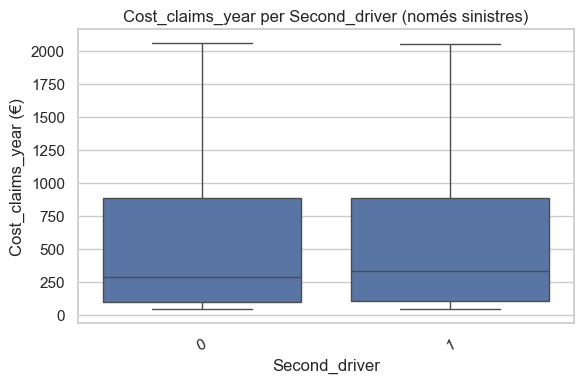


--- Severitat per Has_lapse ---


,mean,median,count
Has_lapse,,,
1,1145.779309,371.17,7710
0,617.860498,250.41,11936


🖼️ Figura desada a: eda/figures\sev_box_Has_lapse.png


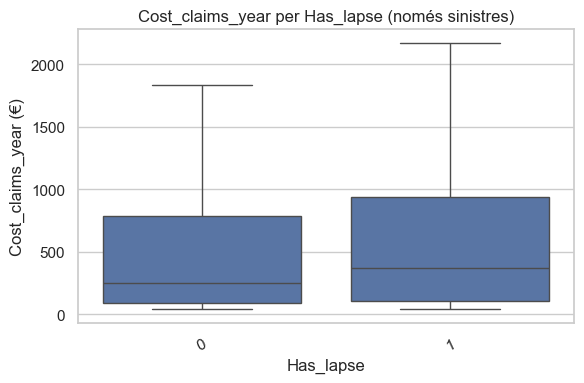


--- Scatterplots severitat vs numèriques ---
🖼️ Figura desada a: eda/figures\sev_scatter_Value_vehicle.png


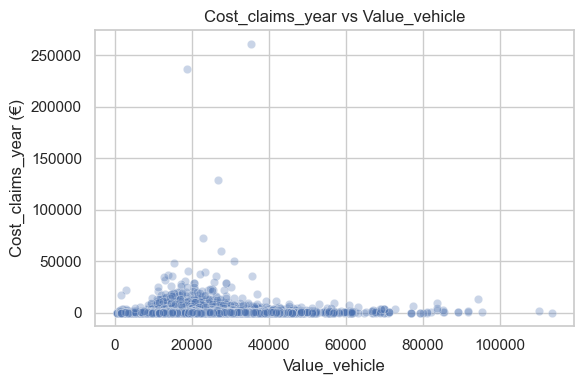

🖼️ Figura desada a: eda/figures\sev_scatter_Premium.png


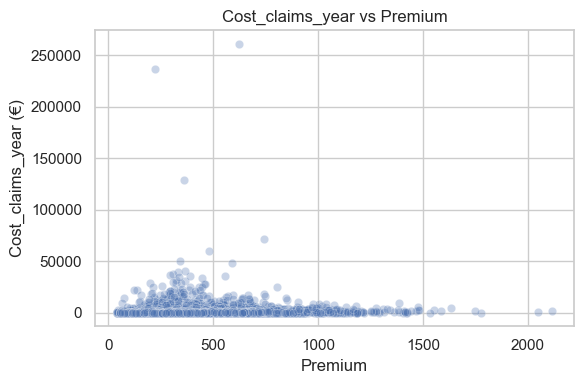

🖼️ Figura desada a: eda/figures\sev_scatter_Power.png


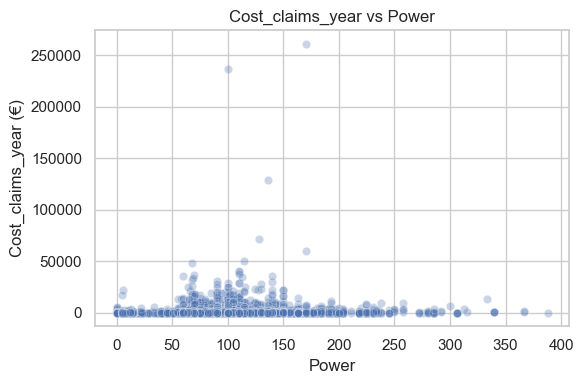

🖼️ Figura desada a: eda/figures\sev_scatter_Vehicle_age.png


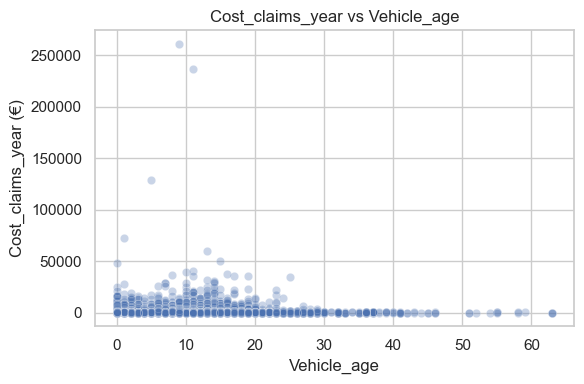

🖼️ Figura desada a: eda/figures\sev_scatter_Driver_age.png


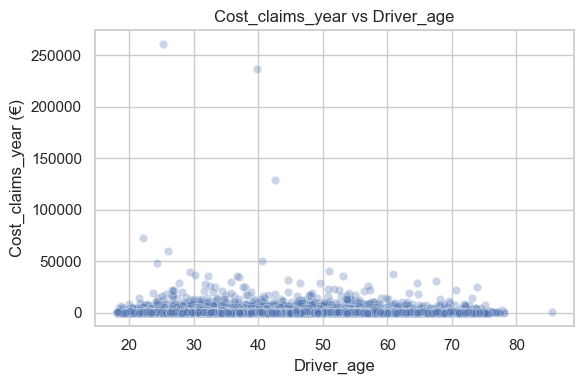

🖼️ Figura desada a: eda/figures\sev_scatter_Licence_age.png


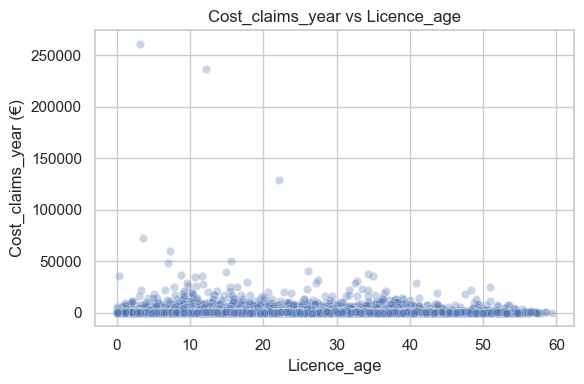

🖼️ Figura desada a: eda/figures\sev_scatter_Length.png


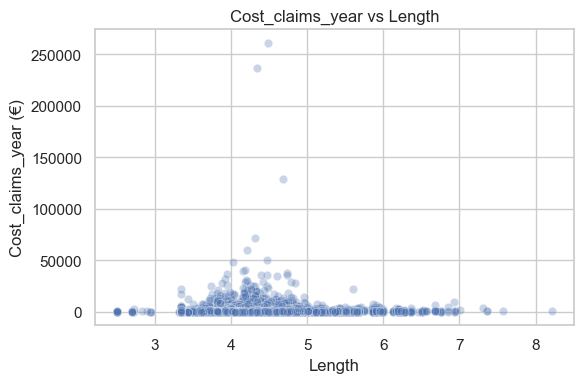

🖼️ Figura desada a: eda/figures\sev_scatter_Weight.png


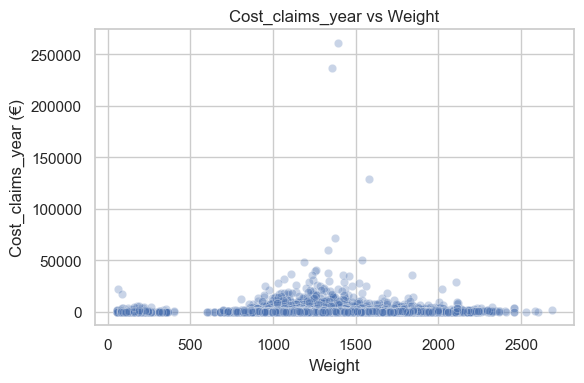

🖼️ Figura desada a: eda/figures\sev_scatter_Cylinder_capacity.png


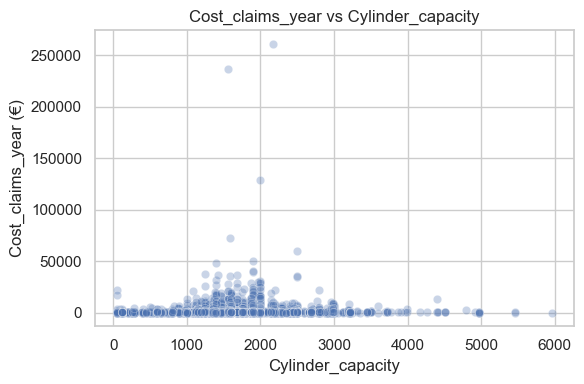


--- Correlacions Spearman amb Cost_claims_year (només sinistres) ---


Premium              0.147233
Value_vehicle        0.100233
Weight               0.079067
Length               0.078743
Power                0.073037
Cylinder_capacity    0.033370
Driver_age          -0.011066
Licence_age         -0.027012
Vehicle_age         -0.073734
Name: Cost_claims_year, dtype: float64

🖼️ Figura desada a: eda/figures\sev_spearman_corr.png


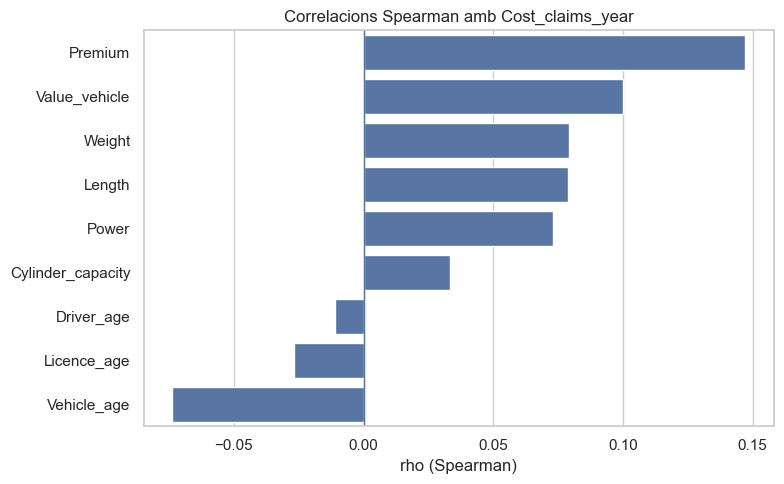


4.3.3.4 completat. Figures desades a eda/figures


In [10]:
# ============================================================
# 4.3.3.4 ANÀLISI DE SEVERITAT (Cost_claims_year)
# ============================================================
# Objectiu:
#   - Analitzar la variable objectiu de severitat **Cost_claims_year**
#     restringint el dataset a pòlisses amb sinistre anual:
#        * Filtre: Has_claims_year = 1 i Cost_claims_year > 0
#   - Avaluar:
#        * Distribució, asimetria i pes dels valors extrems.
#        * Outliers (IQR, z-score) i impacte en la mitjana.
#        * Relacions per segments categòrics (Type_risk, Area,
#          Type_fuel, Distribution_channel, Second_driver).
#        * Relacions bivariants amb predictors numèrics.
#   - Generar les figures essencials per al TFM i annex.
#
# Premisses:
#   - S'assumeix que **df** ja està carregat i tipificat al 4.3.3.1.
#   - No es fan transformacions avançades (ni winsorització, ni log-transform
#     per a modelització, només per diagnòstic visual).
#   - L'anàlisi és purament exploratòria, sense canviar el dataset original.
# ============================================================

# Configuració de display per tenir sortides més llegibles
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
# Estil base dels gràfics
sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# 0) Preparació general
# ------------------------------------------------------------
# Carpeta on desarem tots els gràfics de severitat
os.makedirs("eda/figures", exist_ok=True)
def savefig_sev(filename, dpi=150):
    """
    Desa la figura actual a la carpeta eda/figures amb el nom indicat.
    - filename: nom del fitxer (ex: 'sev_dist_Cost_claims_year.png')
    - dpi: resolució de la imatge
    """
    path = os.path.join("eda/figures", filename)
    plt.tight_layout()          # ajusta marges abans de desar
    plt.savefig(path, dpi=dpi)  # desa la figura com a PNG
    print(f"🖼️ Figura desada a: {path}")
# Variables objectiu
target_freq = "Has_claims_year"   # target de freqüència (0/1)
target_sev  = "Cost_claims_year"  # target de severitat (cost €)
print("Inici 4.3.3.4 - Severitat")
print("Dimensions dataset complet:", df.shape)
# Assegurar que totes les columnes numèriques són realment numèriques
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols_all:
    df[c] = pd.to_numeric(df[c], errors="coerce")  # errors→NaN

# ------------------------------------------------------------
# 1) FILTRE DE SEVERITAT (només pòlisses amb sinistre anual)
# ------------------------------------------------------------
# Ens quedem només amb:
#   - Has_claims_year = 1  → hi ha sinistre en l'any
#   - Cost_claims_year > 0 → cost positiu associat al sinistre
sev_df = df[(df[target_freq] == 1) & (df[target_sev] > 0)].copy()
print("\n--- Filtre severitat aplicat ---")
print("Registres amb sinistre anual:", sev_df.shape[0])
print("Percentatge sobre total:", round(sev_df.shape[0] / df.shape[0] * 100, 2), "%")

# ------------------------------------------------------------
# 2) DISTRIBUCIÓ I ASIMETRIA DE Cost_claims_year
# ------------------------------------------------------------
print("\n--- Estadístiques descriptives Cost_claims_year (només sinistres) ---")
# Estadístiques amb percentils extrems per entendre la cua dreta
sev_summary = sev_df[target_sev].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
display(sev_summary.to_frame().T)
# Histograma en escala original (cost en €)
plt.figure(figsize=(7, 4))
plt.hist(sev_df[target_sev], bins=50)
plt.title("Distribució de Cost_claims_year (només sinistres)")
plt.xlabel("Cost_claims_year (€)")
plt.ylabel("Nombre de sinistres")
savefig_sev("sev_dist_Cost_claims_year.png")  # FIGURA clau
plt.show()
plt.close()
# Boxplot global de Cost_claims_year (ensenya outliers de manera visual)
plt.figure(figsize=(6, 4))
sns.boxplot(x=sev_df[target_sev], orient="h")
plt.title("Boxplot Cost_claims_year (només sinistres)")
plt.xlabel("Cost_claims_year (€)")
savefig_sev("sev_box_Cost_claims_year.png")  # FIGURA clau
plt.show()
plt.close()
# Transformació log(1 + x) per visualitzar millor la cua i l’asimetria
sev_log = np.log1p(sev_df[target_sev])  # log(1 + x) evita problemes amb 0
plt.figure(figsize=(7, 4))
plt.hist(sev_log, bins=50)
plt.title("Distribució log(1 + Cost_claims_year)")
plt.xlabel("log(1 + Cost_claims_year)")
plt.ylabel("Nombre de sinistres")
savefig_sev("sev_dist_log_Cost_claims_year.png")  # FIGURA útil
plt.show()
plt.close()
# Skewness (asimetria) i kurtosis (punxegut de la distribució)
print("\nAsimetria (skewness):", round(sev_df[target_sev].skew(), 3))
print("Curtosi (kurtosis):", round(sev_df[target_sev].kurtosis(), 3))

# ------------------------------------------------------------
# 3) OUTLIERS I PES EN LA MITJANA
# ------------------------------------------------------------
# Sèrie neta de Cost_claims_year (sense infinits i sense NaN)
s = sev_df[target_sev].replace([np.inf, -np.inf], np.nan).dropna()
# Càlcul de l’IQR (Interquartile Range)
q1, q3 = s.quantile([0.25, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
# Outliers segons IQR
iqr_out = s[(s < low) | (s > high)]
iqr_out_pct = round(len(iqr_out) / len(s) * 100, 2)
# Outliers segons Z-score > 3
std = s.std(ddof=0)
if std == 0 or np.isnan(std):
    z_out_pct = 0.0
else:
    z = np.abs((s - s.mean()) / std)
    z_out_pct = round((z > 3).mean() * 100, 2)
print("\n--- Outliers Cost_claims_year ---")
print("Llindars IQR:", round(low, 2), "-", round(high, 2))
print("Outliers IQR (%):", iqr_out_pct)
print("Outliers Z>|3| (%):", z_out_pct)
# Impacte dels outliers en la mitjana
mean_total = s.mean()
mean_wo_out = s[(s >= low) & (s <= high)].mean()
print("\nMitjana amb outliers:", round(mean_total, 2))
print("Mitjana sense outliers IQR:", round(mean_wo_out, 2))
print(
    "Impacte relatiu outliers en la mitjana:",
    round((mean_total / mean_wo_out - 1) * 100, 2),
    "%"
)
# Boxplot amb línies indicant la mitjana amb i sense outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=s, orient="h", color="lightgray", showfliers=True)
plt.axvline(mean_total, linestyle="--", label="Mitjana total")
plt.axvline(mean_wo_out, linestyle=":", label="Mitjana sense outliers IQR")
plt.title("Impacte dels outliers en Cost_claims_year")
plt.xlabel("Cost_claims_year (€)")
plt.legend()
savefig_sev("sev_outliers_impact.png")  # FIGURA clau
plt.show()
plt.close()

# ------------------------------------------------------------
# 4) RELACIONS PER SEGMENTS CATEGÒRICS
# ------------------------------------------------------------
# Factors categòrics d’interès per severitat
cat_factors = [
    "Type_risk", "Area", "Type_fuel",
    "Distribution_channel", "Second_driver", "Has_lapse"
]
# Ens quedem només amb els que existeixen després del filtre

cat_factors = [c for c in cat_factors if c in sev_df.columns]

def sev_by_factor(col):
    """
    Calcula la severitat mitjana, mediana i nombre de casos
    per a cada categoria del factor `col`, ordenats per mitjana descendent.
    """
    tab = sev_df.groupby(col)[target_sev].agg(
        mean="mean", median="median", count="size"
    ).sort_values("mean", ascending=False)
    return tab

for col in cat_factors:
    print(f"\n--- Severitat per {col} ---")
    tab = sev_by_factor(col)
    display(tab)

    # Boxplot del cost per categoria (sense mostrar outliers per evitar que deformin l’escala)
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=sev_df, x=col, y=target_sev, showfliers=False)
    plt.title(f"Cost_claims_year per {col} (només sinistres)")
    plt.ylabel("Cost_claims_year (€)")
    plt.xlabel(col)
    plt.xticks(rotation=25)

    # Guardem una figura per a cada factor categòric analitzat
    savefig_sev(f"sev_box_{col}.png")
    plt.show()
    plt.close()

# ------------------------------------------------------------
# 5) RELACIONS BIVARIANTS AMB NUMÈRIQUES
# ------------------------------------------------------------

# Llista de predictors numèrics potencialment rellevants per severitat
num_predictors_sev = [
    "Value_vehicle", "Premium", "Power",
    "Vehicle_age", "Driver_age", "Licence_age",
    "Length", "Weight", "Cylinder_capacity"
]
# Ens quedem només amb els que existeixen realment en sev_df
num_predictors_sev = [v for v in num_predictors_sev if v in sev_df.columns]

print("\n--- Scatterplots severitat vs numèriques ---")
for v in num_predictors_sev:
    # Seleccionem només files vàlides per a v i target_sev
    sample = sev_df[[v, target_sev]].replace([np.inf, -np.inf], np.nan).dropna()
    # Si hi ha moltes observacions, fem submostreig per evitar figures molt carregades
    if len(sample) > 20000:
        sample = sample.sample(20000, random_state=42)

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=sample, x=v, y=target_sev, alpha=0.3)
    plt.title(f"Cost_claims_year vs {v}")
    plt.ylabel("Cost_claims_year (€)")
    plt.xlabel(v)

    savefig_sev(f"sev_scatter_{v}.png")  # figures per annex
    plt.show()
    plt.close()

# Correlacions de Spearman (més robustes a asimetria i outliers que Pearson)
print("\n--- Correlacions Spearman amb Cost_claims_year (només sinistres) ---")

corr_sev = sev_df[num_predictors_sev + [target_sev]].corr(method="spearman")[target_sev]
# Eliminem la pròpia variable target de la llista i possibles NaN
corr_sev = corr_sev.drop(labels=[target_sev], errors="ignore").dropna()
display(corr_sev.sort_values(ascending=False))

# Barplot de les correlacions Spearman
plt.figure(figsize=(8, 5))
sns.barplot(
    x=corr_sev.sort_values(ascending=False).values,
    y=corr_sev.sort_values(ascending=False).index
)
plt.axvline(0, lw=1)
plt.title("Correlacions Spearman amb Cost_claims_year")
plt.xlabel("rho (Spearman)")
plt.ylabel("")
savefig_sev("sev_spearman_corr.png")  # FIGURA útil de síntesi
plt.show()
plt.close()

print("\n4.3.3.4 completat. Figures desades a eda/figures")


#### <b>4.3.3.5 Anàlisi temporal</b>

Inici 4.3.3.5 - Anàlisi temporal
Dimensions dataset: (105555, 44)

--- Tendència anual de freqüència ---


,claim_rate,n_policies,n_claims
Policy_year,,,
2015,0.299846,4559,1367
2016,0.282805,31428,8888
2017,0.177880,33753,6004
2018,0.094569,35815,3387


Figura desada a: eda/figures\temp_trend_frequency.png


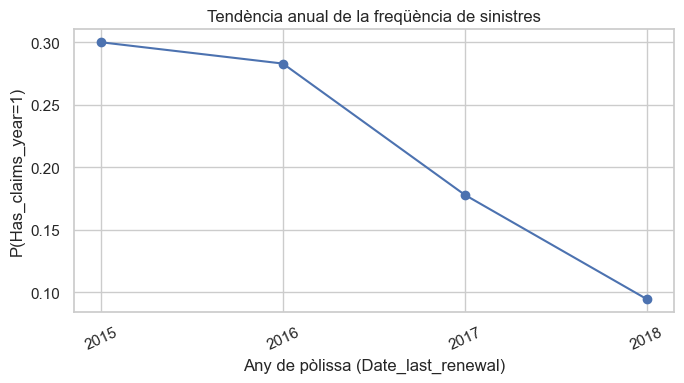


--- Tendència anual de severitat (només sinistres) ---


,mean_sev,median_sev,n_sinistres
Policy_year,,,
2015,872.688274,340.070,1367
2016,871.913203,306.395,8888
2017,824.113188,289.080,6004
2018,684.451246,226.010,3387


Figura desada a: eda/figures\temp_trend_severity.png


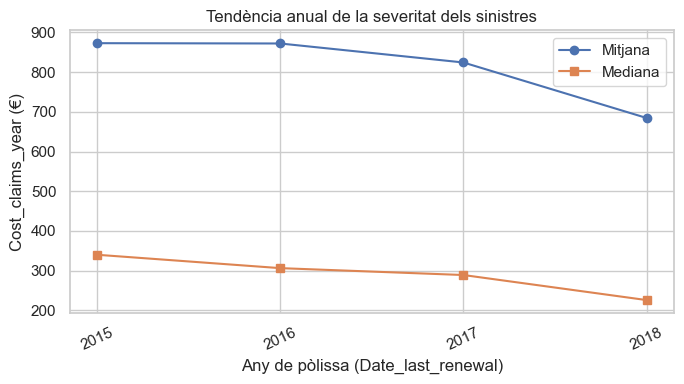


--- Tendència anual de Premium i ràtio cost/prima ---


,mean_premium,median_premium,mean_ratio,median_ratio
Policy_year,,,,
2015,315.770173,290.530,0.788290,0.0
2016,318.451657,296.125,0.736650,0.0
2017,317.952406,293.240,0.479186,0.0
2018,311.721246,287.930,0.205029,0.0


Figura desada a: eda/figures\temp_trend_premium.png


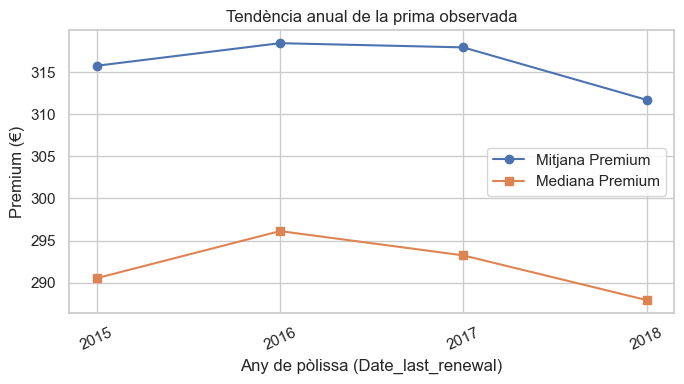

Figura desada a: eda/figures\temp_trend_ratio.png


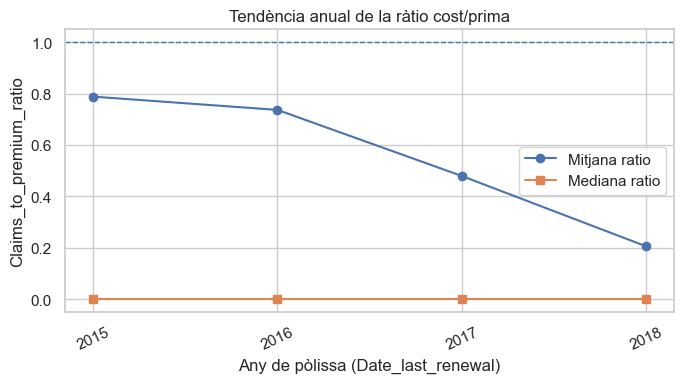


--- Proposta de split temporal ---
Anys disponibles: [2015, 2016, 2017, 2018]
Any frontera suggerit per hold-out temporal: 2017


temporal_split
test     69568
train    35987
Name: count, dtype: int64

temporal_split,test,train
Policy_year,,
2015,0,4559
2016,0,31428
2017,33753,0
2018,35815,0


Figura desada a: eda/figures\temp_split_volume.png


<Figure size 800x400 with 0 Axes>

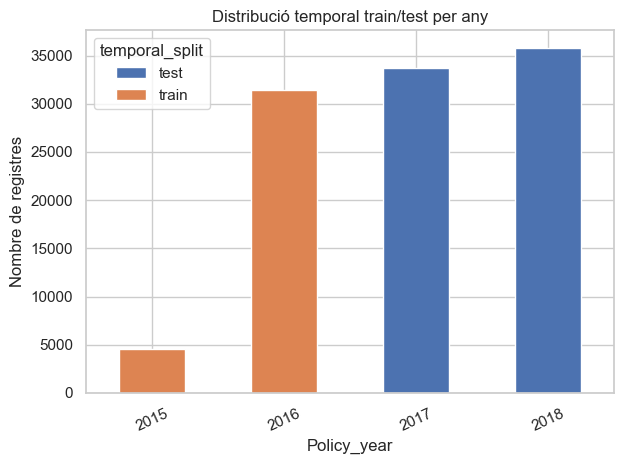


--- Diagnòstic simple de concept drift (train vs test) ---


,mean_train,mean_test,rel_change_%
Cost_claims_year,104.447619,248.493329,137.91
Claims_to_premium_ratio,0.338045,0.743192,119.85
Has_claims_year,0.134990,0.284964,111.10
Area,0.262146,0.296607,13.15
Premium,314.744480,318.111954,1.07
Type_risk,2.715731,2.733543,0.66
Power,92.938046,92.188818,-0.81
Value_vehicle,18567.285102,18116.672696,-2.43
Driver_age,44.744045,43.571397,-2.62
Vehicle_age,9.623706,8.512574,-11.55


Figura desada a: eda/figures\temp_concept_drift_simple.png


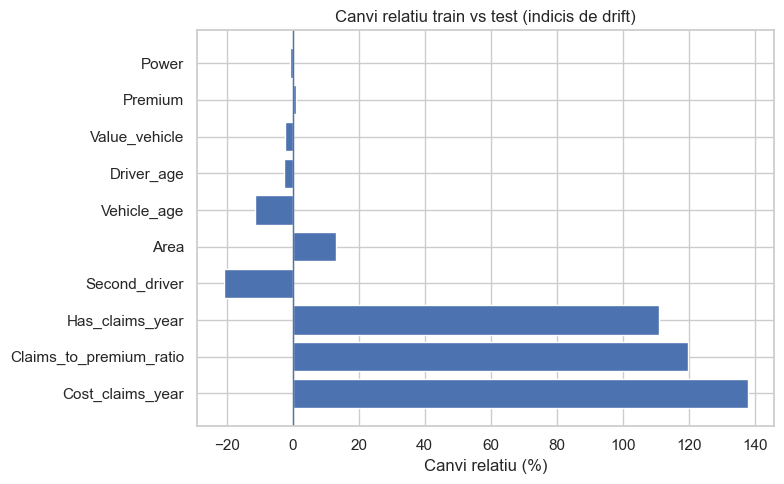


4.3.3.5 completat. Figures desades a eda/figures/


In [12]:
# ============================================================
# 4.3.3.5 ANÀLISI TEMPORAL
# ============================================================
# Objectiu:
#   - Analitzar l’evolució temporal de la sinistralitat:
#        * Tendència anual de freqüència (Has_claims_year)
#        * Tendència anual de severitat (Cost_claims_year) sobre sinistres
#        * Evolució de Premium i ràtio cost/prima
#   - Proposar un esquema de divisió temporal per al modelatge posterior.
#   - Detectar possibles indicis de concept drift (canvis en la distribució
#     del risc en el temps).
#
# Nota:
#   - S'assumeix que **df** ja està carregat i tipificat al 4.3.3.1.
#   - Aquest apartat NO modifica ni transforma dades per al model;
#     només genera diagnòstic temporal exploratori.
#   - Les figures es mostren per pantalla i es desen a eda/figures/.
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Opcions de display per veure millor taules amples
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# Estil visual per defecte dels gràfics
sns.set_theme(style="whitegrid")

# ------------------------------------------------------------
# 0) Preparació general
# ------------------------------------------------------------

# Creem la carpeta per guardar els gràfics de l’EDA temporal
os.makedirs("eda/figures", exist_ok=True)

def savefig_temp(filename, dpi=150):
    """
    Desa la figura actual a la carpeta eda/figures amb el nom indicat.
    Utilitza tight_layout per evitar que es tallin títols/etiquetes.
    """
    path = os.path.join("eda/figures", filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    print(f"Figura desada a: {path}")

print("Inici 4.3.3.5 - Anàlisi temporal")
print("Dimensions dataset:", df.shape)

# Assegurar tipatge de les columnes de data:
# (les 6 dates originals del pipeline)
date_cols = [
    "Date_start_contract", "Date_last_renewal", "Date_next_renewal",
    "Date_birth", "Date_driving_licence", "Date_lapse"
]
# Ens quedem només amb les que realment existeixen al DataFrame
date_cols = [c for c in date_cols if c in df.columns]

# Convertim a datetime qualsevol d’aquestes columnes
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Definim la data de referència temporal del registre.
# Per coherència actuarial amb panel anual, fem servir
# Date_last_renewal com a "any de la pòlissa" (Policy_year).
if "Date_last_renewal" not in df.columns:
    raise ValueError("No existeix Date_last_renewal al dataset. Revisa 4.3.3.1.")

# Extraiem l’any a partir de Date_last_renewal
df["Policy_year"] = df["Date_last_renewal"].dt.year

# Eliminem registres sense any (NaN a Policy_year) per evitar problemes
df_temp = df.dropna(subset=["Policy_year"]).copy()
df_temp["Policy_year"] = df_temp["Policy_year"].astype(int)

# Variables clau per a l’anàlisi
target_freq = "Has_claims_year"          # freqüència (0/1)
target_sev  = "Cost_claims_year"         # cost anual de sinistres
premium_col = "Premium"                  # prima observada
ratio_col   = "Claims_to_premium_ratio"  # cost/prima

# Ens assegurem que aquestes columnes siguin numèriques (si existeixen)
for c in [target_freq, target_sev, premium_col, ratio_col]:
    if c in df_temp.columns:
        df_temp[c] = pd.to_numeric(df_temp[c], errors="coerce")

# ------------------------------------------------------------
# 1) TENDÈNCIA ANUAL DE FREQÜÈNCIA
# ------------------------------------------------------------

print("\n--- Tendència anual de freqüència ---")

# Agrupem per any de pòlissa i calculem:
#   - claim_rate: taxa de sinistre (mitjana de Has_claims_year)
#   - n_policies: nombre de pòlisses per any
#   - n_claims: nombre de pòlisses amb sinistre (suma de Has_claims_year)
freq_year = df_temp.groupby("Policy_year")[target_freq].agg(
    claim_rate="mean",
    n_policies="size",
    n_claims="sum"
).sort_index()

display(freq_year)

# Gràfic de línia de la taxa de sinistre per any
plt.figure(figsize=(7, 4))
plt.plot(freq_year.index.astype(str), freq_year["claim_rate"], marker="o")
plt.title("Tendència anual de la freqüència de sinistres")
plt.xlabel("Any de pòlissa (Date_last_renewal)")
plt.ylabel("P(Has_claims_year=1)")
plt.xticks(rotation=25)
savefig_temp("temp_trend_frequency.png")
plt.show()
plt.close()

# ------------------------------------------------------------
# 2) TENDÈNCIA ANUAL DE SEVERITAT (només sinistres)
# ------------------------------------------------------------

print("\n--- Tendència anual de severitat (només sinistres) ---")

# Filtre de severitat: només registres amb sinistre i cost positiu
sev_only = df_temp[(df_temp[target_freq] == 1) & (df_temp[target_sev] > 0)].copy()

# Agrupem per any de pòlissa i calculem:
#   - mean_sev: severitat mitjana
#   - median_sev: severitat mediana (més robusta a outliers)
#   - n_sinistres: número de sinistres per any
sev_year = sev_only.groupby("Policy_year")[target_sev].agg(
    mean_sev="mean",
    median_sev="median",
    n_sinistres="size"
).sort_index()

display(sev_year)

# Gràfic de línia de la severitat mitjana i mediana per any
plt.figure(figsize=(7, 4))
plt.plot(sev_year.index.astype(str), sev_year["mean_sev"], marker="o", label="Mitjana")
plt.plot(sev_year.index.astype(str), sev_year["median_sev"], marker="s", label="Mediana")
plt.title("Tendència anual de la severitat dels sinistres")
plt.xlabel("Any de pòlissa (Date_last_renewal)")
plt.ylabel("Cost_claims_year (€)")
plt.legend()
plt.xticks(rotation=25)
savefig_temp("temp_trend_severity.png")
plt.show()
plt.close()

# ------------------------------------------------------------
# 3) TENDÈNCIA ECONÒMICA: PREMIUM I RÀTIO COST/PRIMA
# ------------------------------------------------------------

print("\n--- Tendència anual de Premium i ràtio cost/prima ---")

# Agrupem per any i calculem la prima i la ràtio cost/prima
econ_year = df_temp.groupby("Policy_year").agg(
    mean_premium=(premium_col, "mean"),
    median_premium=(premium_col, "median"),
    mean_ratio=(ratio_col, "mean"),
    median_ratio=(ratio_col, "median")
).sort_index()

display(econ_year)

# Gràfic de l’evolució de la prima (mitjana i mediana)
plt.figure(figsize=(7, 4))
plt.plot(econ_year.index.astype(str), econ_year["mean_premium"], marker="o", label="Mitjana Premium")
plt.plot(econ_year.index.astype(str), econ_year["median_premium"], marker="s", label="Mediana Premium")
plt.title("Tendència anual de la prima observada")
plt.xlabel("Any de pòlissa (Date_last_renewal)")
plt.ylabel("Premium (€)")
plt.legend()
plt.xticks(rotation=25)
savefig_temp("temp_trend_premium.png")
plt.show()
plt.close()

# Gràfic de l’evolució de la ràtio cost/prima
plt.figure(figsize=(7, 4))
plt.plot(econ_year.index.astype(str), econ_year["mean_ratio"], marker="o", label="Mitjana ratio")
plt.plot(econ_year.index.astype(str), econ_year["median_ratio"], marker="s", label="Mediana ratio")
plt.axhline(1.0, linestyle="--", linewidth=1)  # línia de referència ratio=1 (cost = prima)
plt.title("Tendència anual de la ràtio cost/prima")
plt.xlabel("Any de pòlissa (Date_last_renewal)")
plt.ylabel("Claims_to_premium_ratio")
plt.legend()
plt.xticks(rotation=25)
savefig_temp("temp_trend_ratio.png")
plt.show()
plt.close()

# ------------------------------------------------------------
# 4) SPLIT TEMPORAL PROPOSAT (per a modelatge)
# ------------------------------------------------------------

print("\n--- Proposta de split temporal ---")

# Llista d’anys disponibles al dataset
years_sorted = sorted(df_temp["Policy_year"].unique())
print("Anys disponibles:", years_sorted)

# Definim una frontera temporal conservadora:
#   - train: anys menys recents
#   - test: últims 1-2 anys (simula dades “futures” per validar)
if len(years_sorted) >= 3:
    split_year = years_sorted[-2]   # antepenúltim any com a frontera
else:
    split_year = years_sorted[-1]   # si no hi ha prou anys, agafem l’últim

print("Any frontera suggerit per hold-out temporal:", split_year)

# Afegim columna que indica si una pòlissa va a train o test
df_temp["temporal_split"] = np.where(
    df_temp["Policy_year"] < split_year,
    "train",
    "test"
)

# Veiem el recompte de registres per partició temporal
display(df_temp["temporal_split"].value_counts())

# Taula amb volum train/test per any de pòlissa
vol_split = df_temp.groupby(["Policy_year", "temporal_split"]).size().unstack(fill_value=0)
display(vol_split)

# Gràfic de barres apilades amb volum per any i split
plt.figure(figsize=(8, 4))
vol_split.plot(kind="bar", stacked=True)
plt.title("Distribució temporal train/test per any")
plt.xlabel("Policy_year")
plt.ylabel("Nombre de registres")
plt.xticks(rotation=25)
savefig_temp("temp_split_volume.png")
plt.show()
plt.close()

# ------------------------------------------------------------
# 5) INDICIS DE CONCEPT DRIFT (diagnòstic simple)
# ------------------------------------------------------------
# Compararem mitjanes de variables clau entre train i test
# per veure si hi ha canvis importants en la distribució.

print("\n--- Diagnòstic simple de concept drift (train vs test) ---")

key_vars = [
    target_freq, target_sev, premium_col, ratio_col,
    "Driver_age", "Vehicle_age", "Power", "Value_vehicle",
    "Type_risk", "Area", "Second_driver"
]
# Ens quedem només amb les variables presents
key_vars = [v for v in key_vars if v in df_temp.columns]

# Calculem la mitjana (numèrica) per a cada variable clau en train i test
drift_table = df_temp.groupby("temporal_split")[key_vars].mean(numeric_only=True).T
drift_table.columns = ["mean_train", "mean_test"]

# Canvi relatiu entre test i train, en %
drift_table["rel_change_%"] = (
    (drift_table["mean_test"] / drift_table["mean_train"] - 1) * 100
).round(2)

display(drift_table.sort_values("rel_change_%", ascending=False))

# Preparem taula per identificar les variables amb més canvi relatiu (absolut)
drift_plot = drift_table.copy()
drift_plot["abs_change"] = drift_plot["rel_change_%"].abs()
top_drift = drift_plot.sort_values("abs_change", ascending=False).head(10)

# Gràfic de barres horitzontals dels canvis relatius més grans
plt.figure(figsize=(8, 5))
plt.barh(top_drift.index, top_drift["rel_change_%"])
plt.axvline(0, lw=1)  # línia vertical a 0 per referència
plt.title("Canvi relatiu train vs test (indicis de drift)")
plt.xlabel("Canvi relatiu (%)")
plt.ylabel("")
savefig_temp("temp_concept_drift_simple.png")
plt.show()
plt.close()

print("\n4.3.3.5 completat. Figures desades a eda/figures/")
